In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from collections import Counter
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report, accuracy_score, log_loss, confusion_matrix, auc, precision_recall_curve, average_precision_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Exploatroy Data Analysis

In [2]:
listings_df = pd.read_csv('listings.csv')
listings_df.head()
listings_df.info()
listings_df.describe(include="all")
listings_df.duplicated().sum()
listings_df.isna().sum()

/tmp/ipykernel_5220/1662594344.py:1: DtypeWarning: Columns (68) have mixed types. Specify dtype option on import or set low_memory=False.
  listings_df = pd.read_csv('listings.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87946 entries, 0 to 87945
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            87946 non-null  int64  
 1   listing_url                                   87946 non-null  object 
 2   scrape_id                                     87946 non-null  int64  
 3   last_scraped                                  87946 non-null  object 
 4   source                                        87946 non-null  object 
 5   name                                          87946 non-null  object 
 6   description                                   86679 non-null  object 
 7   neighborhood_overview                         47190 non-null  object 
 8   picture_url                                   87943 non-null  object 
 9   host_id                                       87946 non-null 

id                                                  0
listing_url                                         0
scrape_id                                           0
last_scraped                                        0
source                                              0
name                                                0
description                                      1267
neighborhood_overview                           40756
picture_url                                         3
host_id                                             0
host_url                                            0
host_name                                           5
host_since                                          5
host_location                                   18778
host_about                                      42040
host_response_time                              28918
host_response_rate                              28918
host_acceptance_rate                            25188
host_is_superhost           

#### Interpretation
Listings dataset contains detailed information on 87,946 Airbnb listings, with attributes ranging from basic details like listing URL, name, and description to more specific data such as host response rates, neighbourhood details, room types, and reviews. Notably, certain columns have a significant number of missing values, such as 'neighborhood_overview' and 'host_about', and some columns like 'neighbourhood_group_cleansed' and 'calendar_updated' are almost entirely empty. The dataset provides a comprehensive view of the listings, including host details, property specifics, and customer reviews, useful for analysis in the hospitality, rental market, and for successful listing classification.

In [3]:
reviews_df = pd.read_csv('reviews.csv')
reviews_count = reviews_df.groupby('listing_id').size()
reviews_count_df = reviews_count.reset_index(name='count')
reviews_count_df = reviews_count_df.rename(columns={'listing_id': 'id'})

merged_df = pd.merge(listings_df.copy(), reviews_count_df, on='id', how='left')
merged_df['count'].fillna(0,inplace=True)
merged_df['counts_match'] = merged_df['number_of_reviews'] == merged_df['count']
merged_df[merged_df['counts_match'] == False].count()

id                                              0
listing_url                                     0
scrape_id                                       0
last_scraped                                    0
source                                          0
name                                            0
description                                     0
neighborhood_overview                           0
picture_url                                     0
host_id                                         0
host_url                                        0
host_name                                       0
host_since                                      0
host_location                                   0
host_about                                      0
host_response_time                              0
host_response_rate                              0
host_acceptance_rate                            0
host_is_superhost                               0
host_thumbnail_url                              0


#### Interpretation
The reviews dataset contains over 1.58 million entries, detailing customer reviews for Airbnb listings, represented by 'listing_id' and 'date' of review. The data covers a wide range of listings (as indicated by the 'listing_id' standard deviation), showcasing the platform's extensive usage. The most frequently reviewed date is July 9, 2023, suggesting a peak in activity or data collection around this time. The dataset is comprehensive, with no missing values in either column, making it a valuable resource for analyzing customer engagement and satisfaction trends over time in the Airbnb market.

Upon examining the unique ID review counts in the reviews dataset and comparing them with the 'number_of_reviews' column in the listings dataset, it was determined that the review information in the listings dataset is complete. Each listing already contains its corresponding review data, indicating that there is no need to merge the datasets for a comprehensive view of review information.

In [4]:
neighbourhoods_df = pd.read_csv('neighbourhoods.csv')
listings_df_neighbourhoods = sorted(listings_df['neighbourhood_cleansed'].str.strip().str.lower().unique())
neighbourhoods_list = sorted(neighbourhoods_df['neighbourhood'].str.strip().str.lower().unique())
neighbourhoods_list == listings_df_neighbourhoods

True

#### Interpretation
The neighbourhoods dataset lists 33 unique neighbourhoods, indicating a focus on a specific region or city, likely within a larger metropolitan area. The 'neighbourhood_group' column, however, is completely null, suggesting either a lack of data collection for this specific attribute or that it's not applicable to the region being analyzed. This dataset provides a clear view of the different neighbourhoods covered but lacks hierarchical or group-level information that could have offered insights into broader regional trends or classifications.

After comparing the unique values from the neighbourhoods dataset with the 'neighbourhood_cleansed' column in the listings dataset, it was found that all locations listed in the neighbourhoods dataset are represented in the listings dataset. This indicates that the listings dataset comprehensively covers all the locations specified in the neighbourhoods dataset, ensuring a complete representation of these areas in the listings information.

### Discussion
The preliminary exploration of the dataset has provided significant insights that are crucial for the initial stages of data processing and analysis. Key observations from the exploratory analysis include:

1. Presence of Null Values: A substantial portion of the dataset contains null values. Importantly, these null values are concentrated in several important columns. A straightforward deletion of rows or columns with missing data is not feasible, as it would result in a loss of over 50% of the dataset. Therefore, more nuanced methods of handling missing data, such as imputation or analysis of missingness patterns, will be required.
2. Inaccurate Data Types: There are instances where the data types assigned to certain columns do not accurately reflect their content. This discrepancy necessitates a thorough review and adjustment of data types to ensure that the dataset is correctly formatted for analysis.
3. Boolean Value Representation: Several columns are intended to represent boolean values but are currently encoded as 't' (true) and 'f' (false) strings. Converting these columns to a standard boolean format (True/False) will streamline data handling and analysis.
4. Consistency Check for Number of Reviews: To validate the 'number_of_reviews' column in the listings dataset, a cross-reference was made with a separate reviews dataset. This comparison was based on unique identifiers and confirmed that the data is consistent across both datasets, lending credibility to the 'number_of_reviews' column.
5. Neighbourhood Data Validation: A comparison was conducted between the unique values in the 'Neighbourhood' column of the listings dataset and an external neighbourhood dataset. This check verified that the neighbourhood data in the listings dataset is consistent with the external source, ensuring the reliability of this particular feature.

These findings form the basis for the next steps in data processing, which will include handling missing values, correcting data types, standardizing boolean representations, and maintaining data integrity through consistent cross-referencing. The goal is to prepare a clean, accurate, and reliable dataset for subsequent analysis.

### Data Preprocessing

In [5]:
replacement_mapping = {'t': 1, 'f': 0}

listings_df['host_has_profile_pic'].replace(replacement_mapping, inplace=True)
listings_df['host_identity_verified'].replace(replacement_mapping, inplace=True)
listings_df['has_availability'].replace(replacement_mapping, inplace=True)
listings_df['instant_bookable'].replace(replacement_mapping, inplace=True)
listings_df['host_is_superhost'].replace(replacement_mapping, inplace=True)

listings_df['price'] = listings_df['price'].replace('[\$,]', '', regex=True).astype(float)
listings_df['host_response_rate'] = listings_df['host_response_rate'].replace('[\%,]', '', regex=True).astype(float)
listings_df['host_acceptance_rate'] = listings_df['host_acceptance_rate'].replace('[\%,]', '', regex=True).astype(float)

listings_df['host_since'] = pd.to_datetime(listings_df['host_since'])
listings_df['first_review'] = pd.to_datetime(listings_df['first_review'])
listings_df['last_review'] = pd.to_datetime(listings_df['last_review'])
listings_df['calendar_last_scraped'] = pd.to_datetime(listings_df['calendar_last_scraped'])

columns_to_replace_nan = [
    'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
    'host_has_profile_pic', 'host_identity_verified', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 
    'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
    'availability_30', 'availability_60', 'availability_90', 'availability_365', 'review_scores_rating', 'review_scores_accuracy', 
    'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 
    'host_response_time', 'reviews_per_month'
]

for column in columns_to_replace_nan:
    listings_df[column].fillna(0, inplace=True)

listings_df['neighbourhood_cleansed'] = listings_df['neighbourhood_cleansed'].str.strip().str.lower()
listings_df['property_type'] = listings_df['property_type'].str.strip().str.lower()
listings_df['room_type'] = listings_df['room_type'].str.strip().str.lower()

listings_df.isna().sum()

id                                                  0
listing_url                                         0
scrape_id                                           0
last_scraped                                        0
source                                              0
name                                                0
description                                      1267
neighborhood_overview                           40756
picture_url                                         3
host_id                                             0
host_url                                            0
host_name                                           5
host_since                                          5
host_location                                   18778
host_about                                      42040
host_response_time                                  0
host_response_rate                                  0
host_acceptance_rate                                0
host_is_superhost           

In [6]:
def extract_rooms(description):
    if isinstance(description, str):
        match = re.search(r'(\d+)\s+(?:bedroom|room|bedrooms|rooms)', description, re.IGNORECASE)
        if match:
            return int(match.group(1))
    return None

listings_df['bedrooms_new'] = listings_df['name'].apply(extract_rooms)
listings_df['bedrooms'] = listings_df['bedrooms'].combine_first(listings_df['bedrooms_new'])
listings_df['beds'] = listings_df['beds'].fillna(listings_df['bedrooms'])

def extract_bath_number(bath_description):
    if isinstance(bath_description, str):
        match = re.search(r'(\d+\.?\d*)', bath_description)
        if match:
            return float(match.group(1))
    return None

listings_df['bathroom_new'] = listings_df['bathrooms_text'].apply(extract_bath_number)
listings_df['bathrooms'] = listings_df['bathrooms'].combine_first(listings_df['bathroom_new'])

def check_presence(row, value):
    if pd.isna(row):
        return 0
    if value in row:
        return 1
    return 0

listings_df['isVerifiedEmail'] = listings_df['host_verifications'].apply(lambda row: check_presence(row, 'email'))
listings_df['isVerifiedPhone'] = listings_df['host_verifications'].apply(lambda row: check_presence(row, 'phone'))
listings_df['isVerifiedWorkEmail'] = listings_df['host_verifications'].apply(lambda row: check_presence(row, 'work_email'))
listings_df['isVerifiedPhotographer'] = listings_df['host_verifications'].apply(lambda row: check_presence(row, 'photographer'))

listings_df.replace(',', '', regex=True, inplace=True)
listings_df.to_csv('preprocessed_data.csv', index = False)
listings_df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,bedrooms_new,bathroom_new,isVerifiedEmail,isVerifiedPhone,isVerifiedWorkEmail,isVerifiedPhotographer
0,92644,https://www.airbnb.com/rooms/92644,20230906022807,2023-09-06,city scrape,Rental unit in Earlsfield · ★4.57 · 1 bedroom ...,<b>The space</b><br />Hi everyone! I have 2 ro...,NaN,https://a0.muscache.com/pictures/715127/85bdb4...,498201,https://www.airbnb.com/users/show/498201,Dee Dee,2011-04-10,London United Kingdom,I am employed at St Georges hospital in tootin...,0,0.0,100.0,0.0,https://a0.muscache.com/im/pictures/user/0edcb...,https://a0.muscache.com/im/pictures/user/0edcb...,Earlsfield,1.0,1.0,['email' 'phone'],1.0,1.0,NaN,wandsworth,NaN,51.44201,-0.18739,private room in rental unit,private room,2,1.5,1.5 shared baths,1.0,2.0,"[""Heating"" ""TV with standard cable"" ""Wifi"" ""Sm...",42.0,2,730,2.0,2.0,1125.0,1125.0,2.0,1125.0,NaN,1,0,0,0,217,2023-09-06,216,9,0,2011-06-21,2022-10-29,4.57,4.74,4.86,4.71,4.67,4.53,4.68,NaN,1,1,0,1,0,1.45,1.0,1.5,1,1,0,0
1,93015,https://www.airbnb.com/rooms/93015,20230906022807,2023-09-06,city scrape,Rental unit in Hammersmith · ★4.82 · 2 bedroom...,Gorgeous 2 bed ground floor apartment with per...,A bit of history about the W14 area: <br />Com...,https://a0.muscache.com/pictures/865937ec-ee56...,499704,https://www.airbnb.com/users/show/499704,Sarah,2011-04-11,London United Kingdom,Been living in London for over 20 years and I ...,within a few hours,100.0,25.0,0.0,https://a0.muscache.com/im/pictures/user/452ff...,https://a0.muscache.com/im/pictures/user/452ff...,Hammersmith,1.0,2.0,['email' 'phone'],1.0,1.0,Hammersmith England United Kingdom,hammersmith and fulham,NaN,51.49993,-0.21707,entire rental unit,entire home/apt,5,1.0,1 bath,2.0,3.0,"[""Window guards"" ""Bathtub"" ""Hot water kettle"" ...",175.0,5,240,5.0,5.0,240.0,240.0,5.0,240.0,NaN,1,13,18,38,40,2023-09-06,38,2,0,2012-02-01,2022-09-30,4.82,4.76,4.62,4.85,4.88,4.85,4.74,NaN,0,1,1,0,0,0.27,2.0,1.0,1,1,0,0
2,13913,https://www.airbnb.com/rooms/13913,20230906022807,2023-09-06,city scrape,Rental unit in Islington · ★4.80 · 1 bedroom ·...,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,https://www.airbnb.com/users/show/54730,Alina,2009-11-16,London United Kingdom,I am a Multi-Media Visual Artist and Creative ...,within a few hours,100.0,88.0,0.0,https://a0.muscache.com/im/users/54730/profile...,https://a0.muscache.com/im/users/54730/profile...,LB of Islington,3.0,4.0,['email' 'phone'],1.0,1.0,Islington Greater London United Kingdom,islington,NaN,51.56861,-0.11270,private room in rental unit,private room,1,1.0,1 shared bath,1.0,1

### Discussion

The data preprocessing steps applied to the Airbnb listings dataset involve several key transformations to ensure data consistency and usability. Firstly, categorical 'True/False' columns are converted to numeric '1/0' values for easier analysis. Monetary and percentage values in columns like 'price', 'host_response_rate', and 'host_acceptance_rate' are cleaned of non-numeric characters and converted to floats. Date columns are standardized to datetime format. Columns with missing values are filled with zeros, and text-based attributes like 'neighbourhood_cleansed', 'property_type', and 'room_type' are normalized to lower case and trimmed of whitespace. Additionally, new columns are derived from existing data, such as extracting room and bathroom counts from descriptions, and creating flags for various host verifications. 

### Data Visualizations

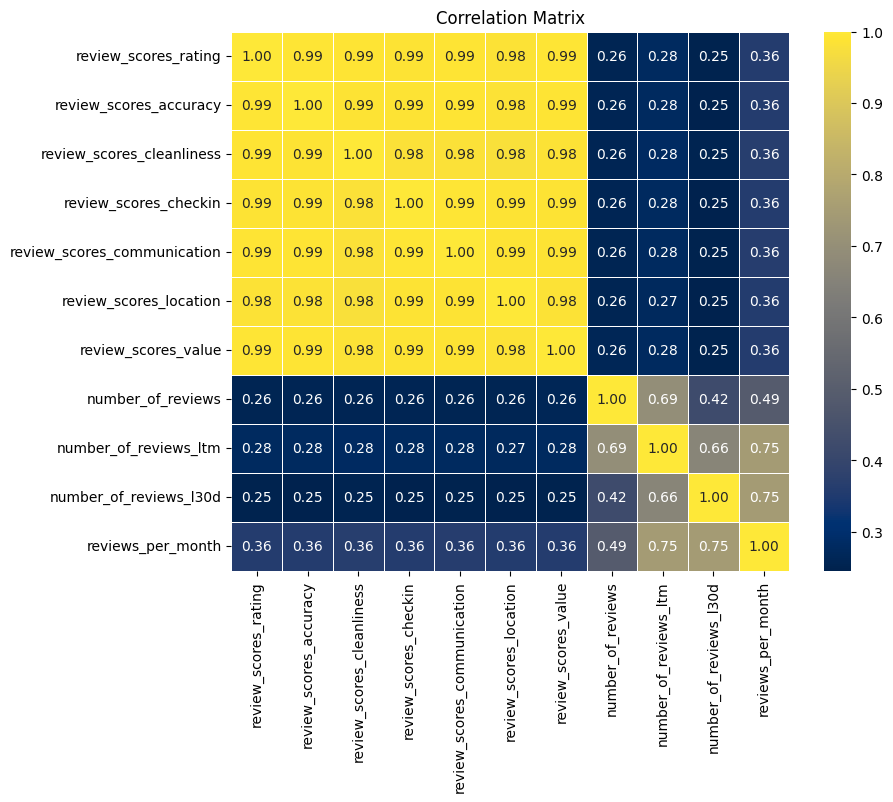

In [7]:
correlation_matrix = listings_df[[
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value',
    'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'reviews_per_month']].corr()
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='cividis', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

#### Interpretation
The correlation matrix indicates extremely high correlations (above 0.98) among various review scores categories such as rating, accuracy, cleanliness, check-in, communication, location, and value. This suggests redundancy among these features, which could be problematic for some of predictive modeling due to multicollinearity.

For feature engineering, these highly correlated review scores could be combined into a single feature representing overall review quality. This single feature would capture the essence of the overall guest satisfaction without the redundancy of multiple correlated variables, potentially improving model performance and interpretability.

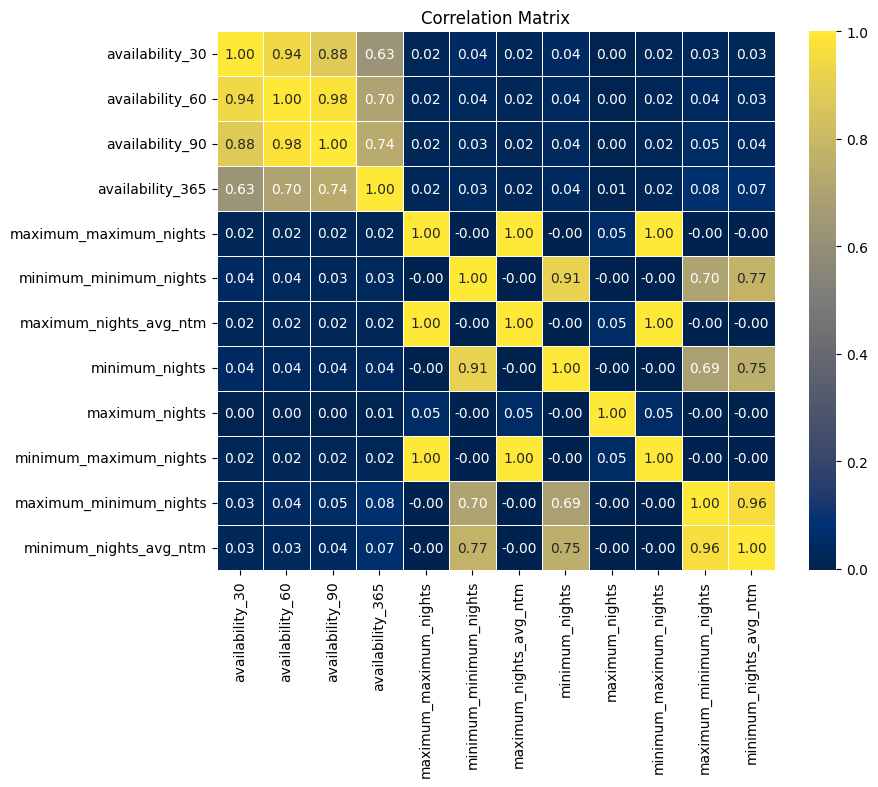

In [8]:
correlation_matrix = listings_df[[
    'availability_30', 'availability_60', 'availability_90', 'availability_365', 'maximum_maximum_nights', 
    'minimum_minimum_nights', 'maximum_nights_avg_ntm','minimum_nights', 'maximum_nights', 'minimum_maximum_nights',
    'maximum_minimum_nights', 'minimum_nights_avg_ntm']].corr()
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='cividis', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

#### Interpretation
The correlation matrix shows strong correlations among availability metrics (availability_30, availability_60, availability_90, and availability_365) as well as various metrics for minimum and maximum nights. These strong correlations suggest redundancy.

In terms of feature engineering, I will aggregate availability into a single feature that captures the overall availability trend, perhaps by averaging these values and by using a weighted sum that prioritizes longer-term availability. Similarly, the maximum and minimum nights could be combined into a single feature that represents the typical length of stay the property is available for, using methods such as averaging and calculating a weighted range. This would reduce the feature space and potentially improve the performance of machine learning models by reducing multicollinearity.

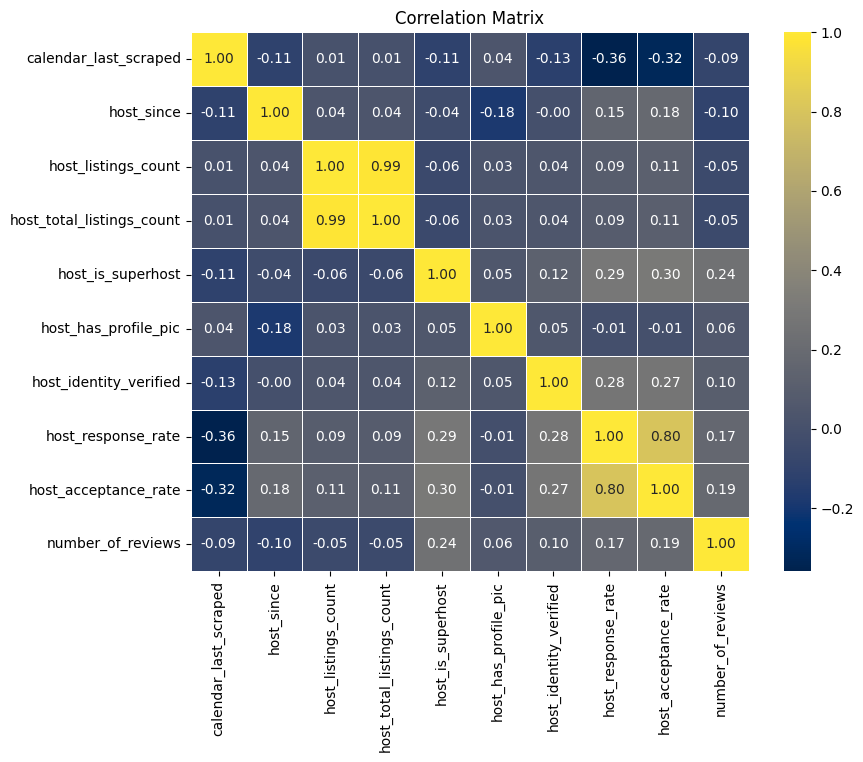

In [9]:
correlation_matrix = listings_df[[
    'calendar_last_scraped', 'host_since', 'host_listings_count', 'host_total_listings_count', 'host_is_superhost', 
    'host_has_profile_pic', 'host_identity_verified', 'host_response_rate', 'host_acceptance_rate',
    'number_of_reviews']].corr()
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='cividis', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

#### Interpretation
The correlation matrix shows a very strong correlation between host_listings_count and host_total_listings_count, indicating they are essentially duplicates, and a strong correlation between host_response_rate and host_acceptance_rate.

For feature engineering, host_listings_count and host_total_listings_count could be represented by a single feature to avoid redundancy. The host_response_rate and host_acceptance_rate could be combined into a single metric that reflects overall host responsiveness and acceptance.

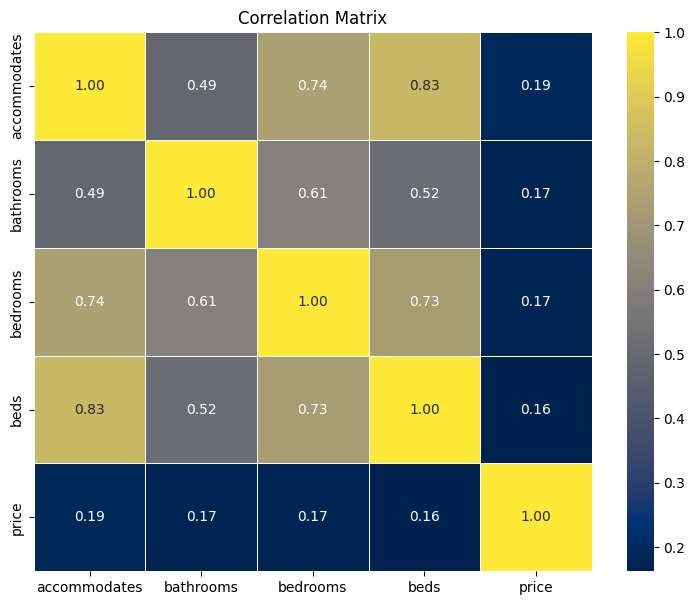

In [10]:
correlation_matrix = listings_df[[
    'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price']].corr()
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='cividis', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

#### Interpretation
The correlation matrix suggests strong relationships between 'accommodates', 'bedrooms', and 'beds', which makes sense as these typically increase together in larger properties. 'Price' has a lower correlation with these features, indicating it may be influenced by more factors than just size.

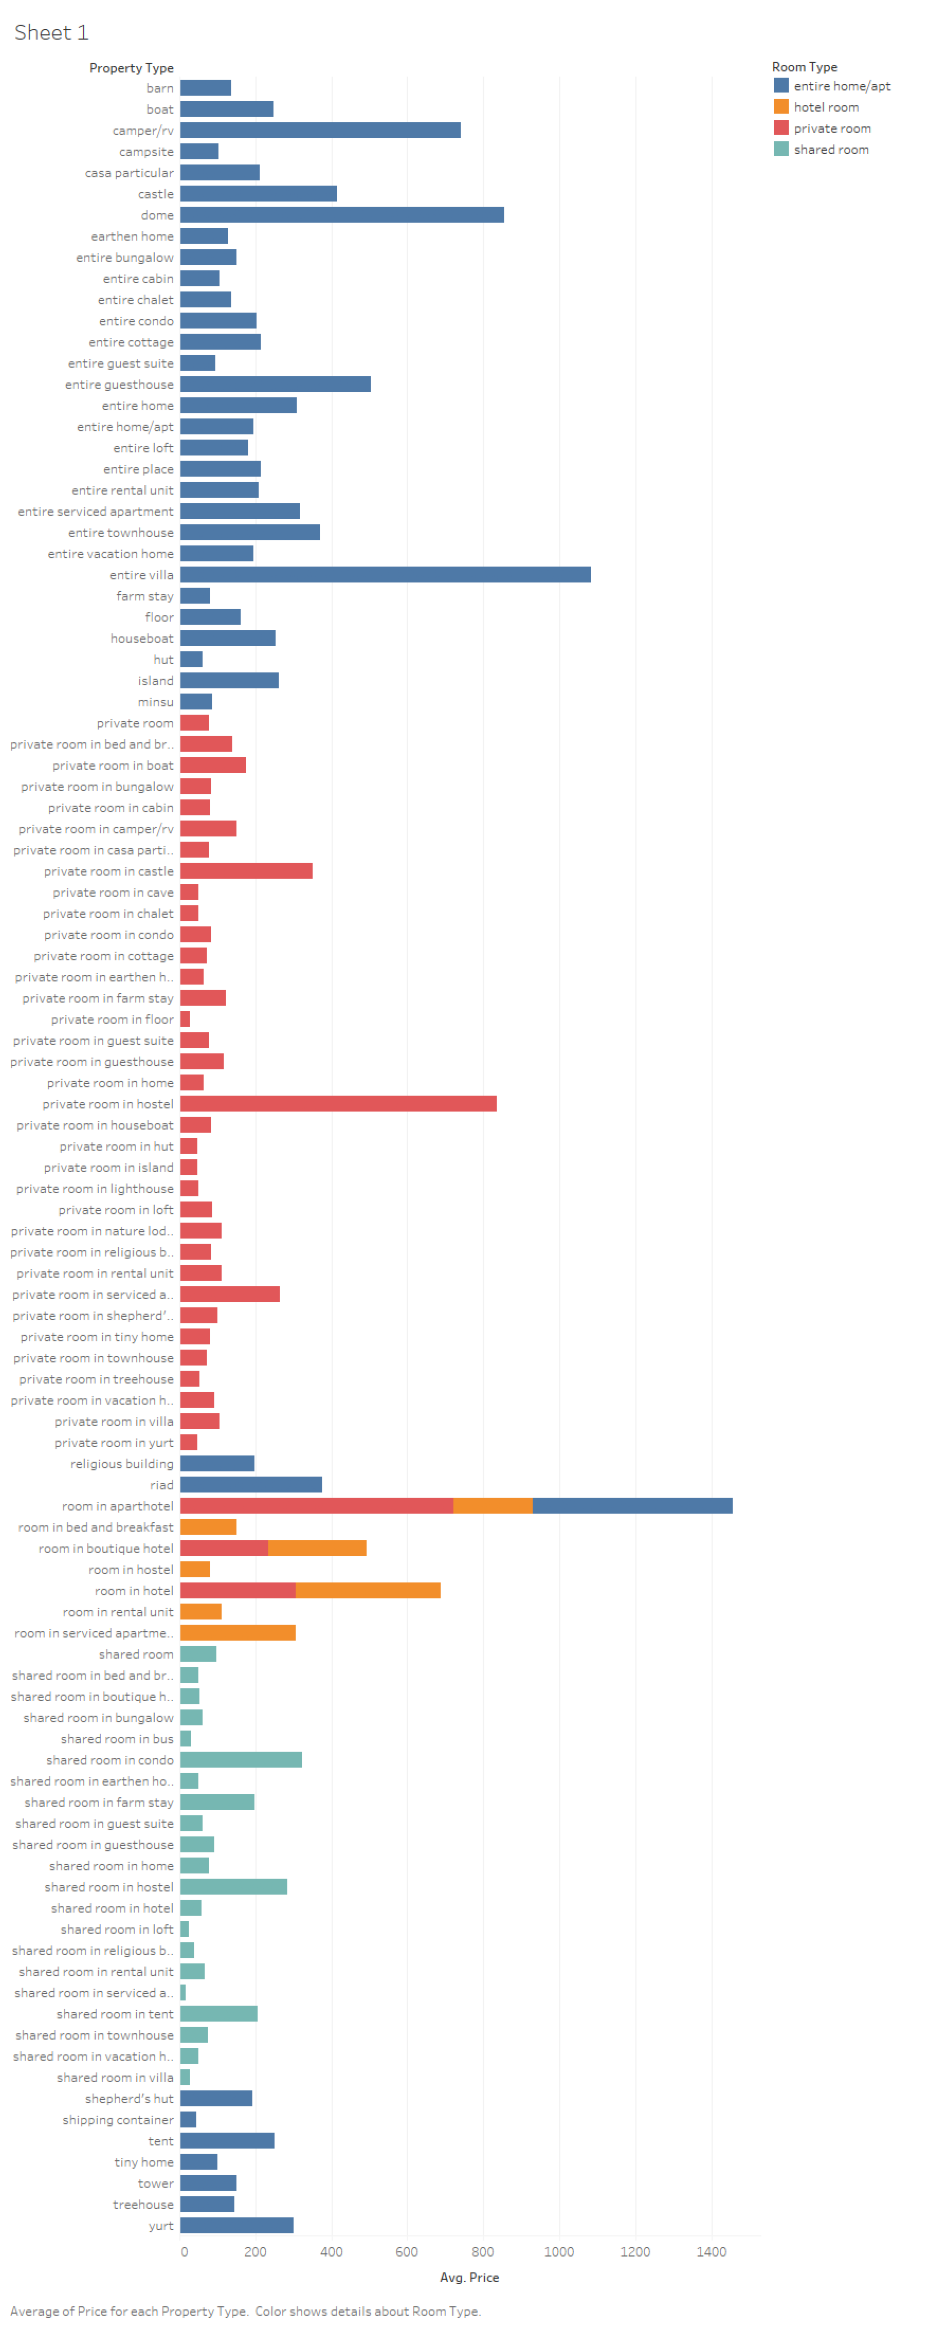

In [11]:
img = mpimg.imread('Sheet 1.png')
plt.figure(figsize=(20, 30))
plt.imshow(img)
plt.axis('off')
plt.show()

#### Interpretation
Displays a comparison of average prices for various property types and room types. Properties like entire homes/apartments tend to have higher average prices compared to private rooms and shared rooms.

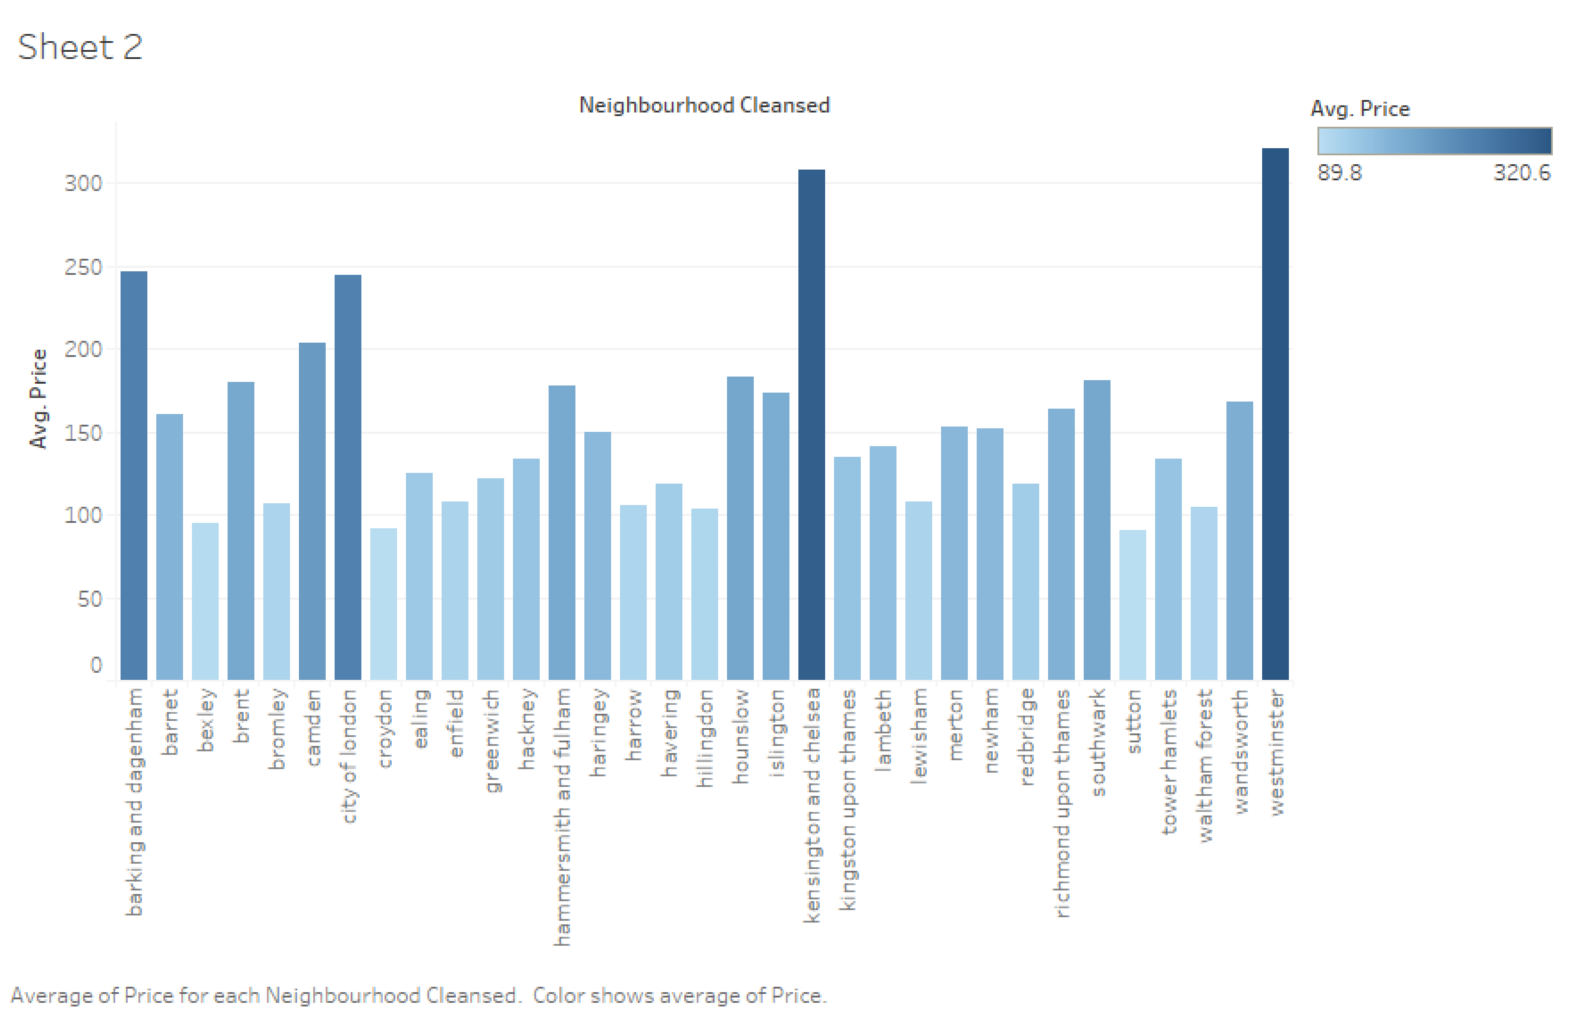

In [12]:
img = mpimg.imread('Sheet 2.png')
plt.figure(figsize=(20, 30))
plt.imshow(img)
plt.axis('off')
plt.show()

#### Interpretation
Shows the average price of accommodations in different neighborhoods. There is significant variation in price, indicating that location is a key factor in accommodation pricing.

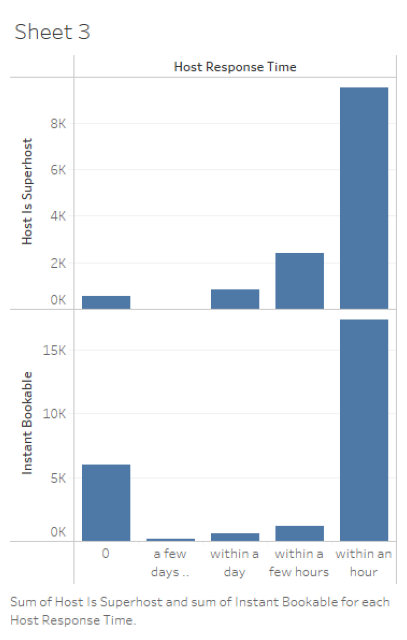

In [13]:
img = mpimg.imread('Sheet 3.png')
plt.figure(figsize=(5, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

#### Interpretation
Illustrates the relationship between the number of hosts who are classified as superhosts and their response times. There is a clear trend showing that a majority of superhosts respond within a few hours, suggesting that responsiveness might be related to the superhost status.

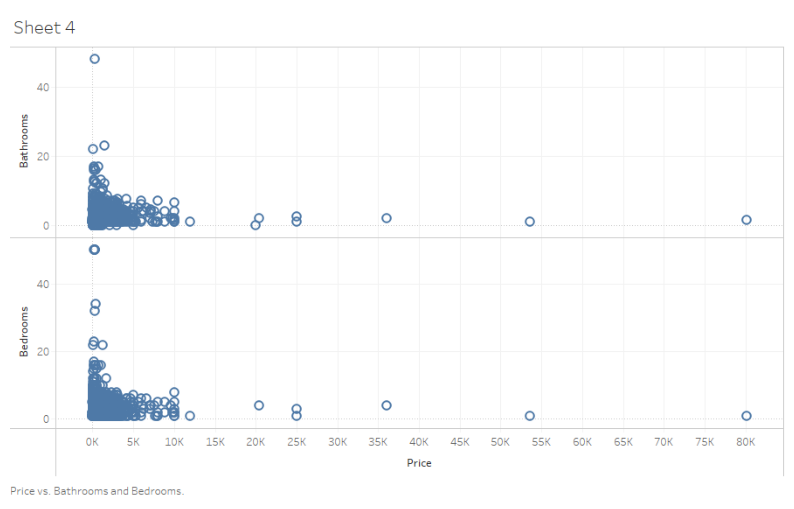

In [14]:
img = mpimg.imread('Sheet 4.png')
plt.figure(figsize=(10, 20))
plt.imshow(img)
plt.axis('off')
plt.show()

#### Interpretation
Depicts the distribution of prices based on the number of bathrooms and bedrooms. There is a wide distribution of prices, but generally, the price increases with the number of bedrooms and bathrooms.

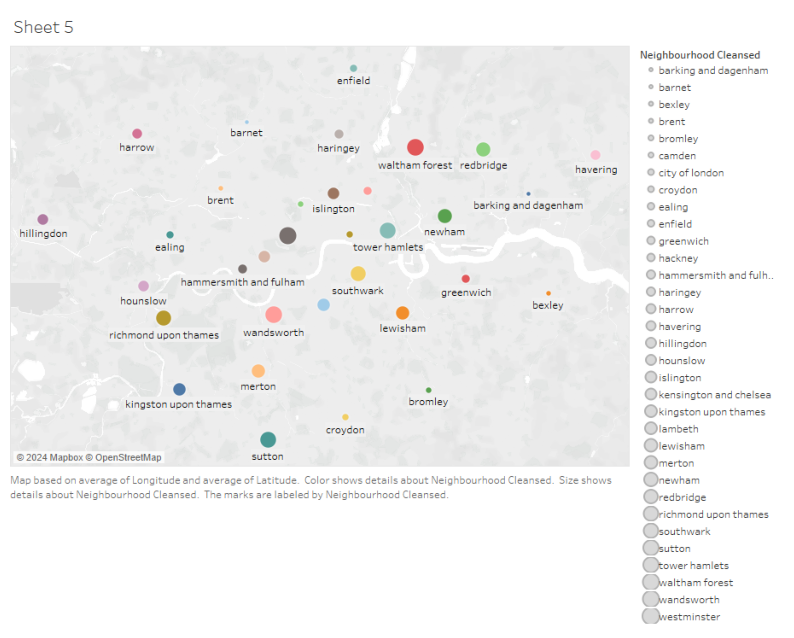

In [15]:
img = mpimg.imread('Sheet 5.png')
plt.figure(figsize=(10, 20))
plt.imshow(img)
plt.axis('off')
plt.show()

#### Interpretation
A map visualization showing number of listings across different neighborhoods with size of the dots and neighborhoods are color-coded information.

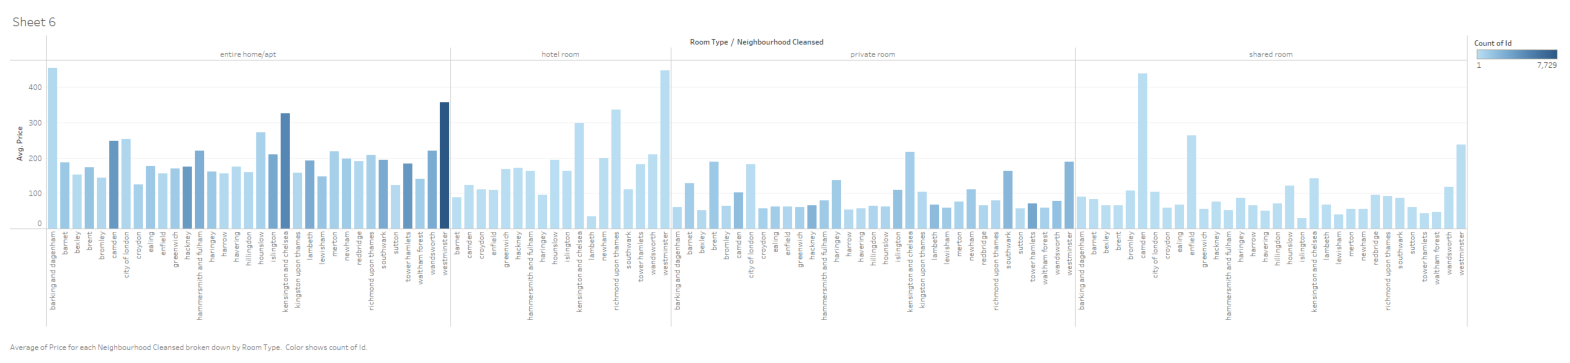

In [16]:
img = mpimg.imread('Sheet 6.png')
plt.figure(figsize=(20, 30))
plt.imshow(img)
plt.axis('off')
plt.show()

#### Interpretation
A bar graph breaking down the average price for accommodations by neighborhood and room type. Entire homes/apartments typically have higher average prices across neighborhoods compared to hotel rooms and private rooms.

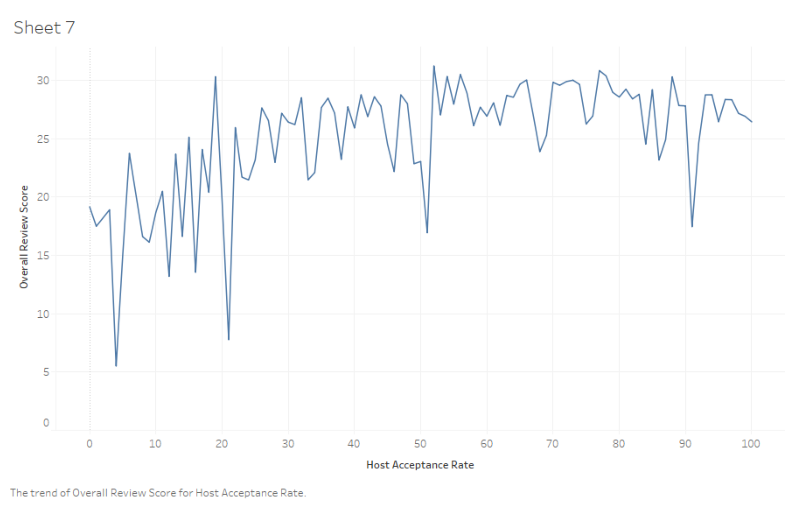

In [17]:
img = mpimg.imread('Sheet 7.png')
plt.figure(figsize=(10, 20))
plt.imshow(img)
plt.axis('off')
plt.show()

#### Interpretation
This line graph shows the trend of overall review scores as they relate to the host acceptance rate. The trend suggests that hosts with higher acceptance rates tend to have better review scores, although there are some fluctuations.

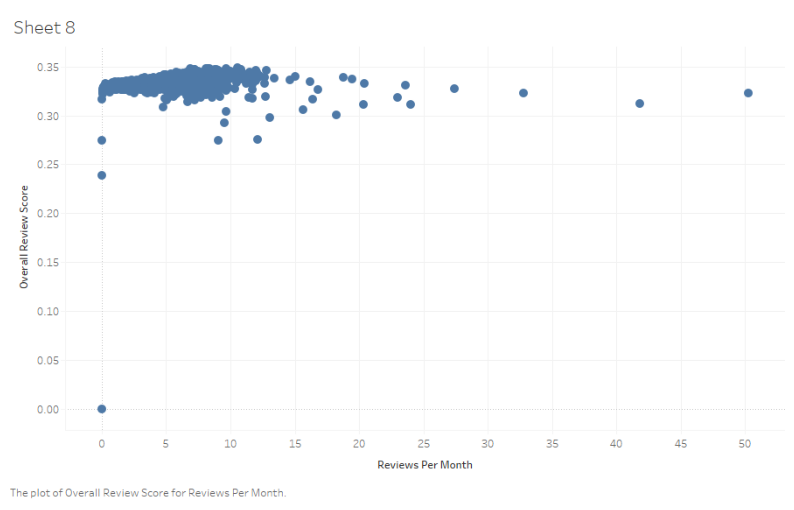

In [18]:
img = mpimg.imread('Sheet 8.png')
plt.figure(figsize=(10, 20))
plt.imshow(img)
plt.axis('off')
plt.show()

#### Interpretation
A scatter plot of overall review scores against the number of reviews per month. There seems to be a cluster of listings with a high number of reviews per month maintaining a relatively high review score.

### Discussion
For Visual Data Analysis I initially started with Altair in Python, the shift to Tableau was necessitated due to dataset size and system limitations, enabling more efficient handling and visualization of large data.

- **Review Scores Aggregation:** High correlations among review categories (rating, accuracy, cleanliness, check-in, etc.) suggest redundancy. Aggregating these into a single 'overall review quality' metric can simplify the model and capture essential information.
- **Availability and Stay Length Metrics:** Strong correlations among various availability metrics and between minimum/maximum nights suggest redundancy. Combining these into singular features representing overall availability trends and typical stay length can streamline the feature set.
- **Host Metrics Combination:** The overlap between 'host_listings_count' and 'host_total_listings_count', as well as between 'host_response_rate' and 'host_acceptance_rate', indicates redundancy. Merging these into consolidated features can reduce duplicity and improve model efficiency.
- **Property Size and Price Correlations:** The relationship between 'accommodates', 'bedrooms', 'beds', and 'price' is investigated, revealing that larger properties tend to be pricier, but price is influenced by multiple factors.
- **Geographical and Property Type Price Analysis:** Visualizations in Tableau show variations in prices based on property types, room types, and neighbourhoods, highlighting the impact of location and property type on pricing.
- **Superhost Status and Responsiveness:** Analysis of superhost status and host response times suggests a correlation, where superhosts tend to be more responsive.

### Feature Engineering

In [19]:
all_amenities = set()
for amenities_list in listings_df['amenities']:
    all_amenities.update(eval(amenities_list))

categories = {
    'High-Speed Wi-Fi': ['Wi-Fi', 'Wifi', 'Internet'],
    'Air Conditioning/Heating': ['Air Conditioning', 'Heating', 'AC', 'HVAC'],
    'Well-Equipped Kitchen': ['Kitchen', 'Stove', 'Oven', 'Refrigerator', 'Microwave', 'Dishwasher'],
    'Quality Bedding and Mattresses': ['Bed', 'Mattress', 'Linen', 'Pillow'],
    'Washer and Dryer': ['Washer', 'Dryer', 'Laundry', 'Washing Machine'],
    'Smart TV with Streaming Services': ['Smart TV', 'HDTV', 'Netflix', 'Amazon Prime', 'Disney+', 'Chromecast'],
    'Private Parking Space': ['Parking', 'Garage'],
    'Outdoor Space (Balcony, Garden, Patio)': ['Balcony', 'Garden', 'Patio', 'Terrace'],
    'Fitness Amenities (Home Gym, Yoga Mats)': ['Gym', 'Fitness', 'Yoga Mat', 'Exercise'],
    'Personal Touches (Local Guides, Recommendations)': ['Guide', 'Recommendation', 'Map', 'Local Tips'],
    'Security Features (Smart Locks, Security Systems)': ['Security', 'Smart Lock', 'Alarm'],
    'Eco-Friendly Options (Solar Panels, Energy-Efficient Appliances)': ['Solar Panel', 'Energy-Efficient', 'Eco-Friendly'],
    'Others': ['']
}

for category in categories:
    listings_df[category] = 0

def update_categories(row_index, row):
    try:
        amenities_list = eval(row['amenities'])
    except:
        amenities_list = []
    
    for amenity in amenities_list:
        for category, keywords in categories.items():
            if any(re.search(rf'\b{keyword}\b', amenity, re.IGNORECASE) for keyword in keywords):
                listings_df.at[row_index, category] = 1
                break

for index, row in listings_df.iterrows():
    update_categories(index, row)

columns_to_count = [
    'High-Speed Wi-Fi', 'Air Conditioning/Heating', 'Well-Equipped Kitchen',
    'Quality Bedding and Mattresses', 'Washer and Dryer', 'Smart TV with Streaming Services',
    'Private Parking Space', 'Outdoor Space (Balcony, Garden, Patio)', 'Fitness Amenities (Home Gym, Yoga Mats)',
    'Personal Touches (Local Guides, Recommendations)', 'Security Features (Smart Locks, Security Systems)',
    'Eco-Friendly Options (Solar Panels, Energy-Efficient Appliances)', 'Others'
]

listings_df['amenitiesCount'] = listings_df[columns_to_count].sum(axis=1)

listings_df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,bedrooms_new,bathroom_new,isVerifiedEmail,isVerifiedPhone,isVerifiedWorkEmail,isVerifiedPhotographer,High-Speed Wi-Fi,Air Conditioning/Heating,Well-Equipped Kitchen,Quality Bedding and Mattresses,Washer and Dryer,Smart TV with Streaming Services,Private Parking Space,"Outdoor Space (Balcony, Garden, Patio)","Fitness Amenities (Home Gym, Yoga Mats)","Personal Touches (Local Guides, Recommendations)","Security Features (Smart Locks, Security Systems)","Eco-Friendly Options (Solar Panels, Energy-Efficient Appliances)",Others,amenitiesCount
0,92644,https://www.airbnb.com/rooms/92644,20230906022807,2023-09-06,city scrape,Rental unit in Earlsfield · ★4.57 · 1 bedroom ...,<b>The space</b><br />Hi everyone! I have 2 ro...,NaN,https://a0.muscache.com/pictures/715127/85bdb4...,498201,https://www.airbnb.com/users/show/498201,Dee Dee,2011-04-10,London United Kingdom,I am employed at St Georges hospital in tootin...,0,0.0,100.0,0.0,https://a0.muscache.com/im/pictures/user/0edcb...,https://a0.muscache.com/im/pictures/user/0edcb...,Earlsfield,1.0,1.0,['email' 'phone'],1.0,1.0,NaN,wandsworth,NaN,51.44201,-0.18739,private room in rental unit,private room,2,1.5,1.5 shared baths,1.0,2.0,"[""Heating"" ""TV with standard cable"" ""Wifi"" ""Sm...",42.0,2,730,2.0,2.0,1125.0,1125.0,2.0,1125.0,NaN,1,0,0,0,217,2023-09-06,216,9,0,2011-06-21,2022-10-29,4.57,4.74,4.86,4.71,4.67,4.53,4.68,NaN,1,1,0,1,0,1.45,1.0,1.5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,93015,https://www.airbnb.com/rooms/93015,20230906022807,2023-09-06,city scrape,Rental unit in Hammersmith · ★4.82 · 2 bedroom...,Gorgeous 2 bed ground floor apartment with per...,A bit of history about the W14 area: <br />Com...,https://a0.muscache.com/pictures/865937ec-ee56...,499704,https://www.airbnb.com/users/show/499704,Sarah,2011-04-11,London United Kingdom,Been living in London for over 20 years and I ...,within a few hours,100.0,25.0,0.0,https://a0.muscache.com/im/pictures/user/452ff...,https://a0.muscache.com/im/pictures/user/452ff...,Hammersmith,1.0,2.0,['email' 'phone'],1.0,1.0,Hammersmith England United Kingdom,hammersmith and fulham,NaN,51.49993,-0.21707,entire rental unit,entire home/apt,5,1.0,1 bath,2.0,3.0,"[""Window guards"" ""Bathtub"" ""Hot water kettle"" ...",175.0,5,240,5.0,5.0,240.0,240.0,5.0,240.0,NaN,1,13,18,38,40,2023-09-06,38,2,0,2012-02-01,2022-09-30,4.82,4.76,4.62,4.85,4.88,4.85,4.74,NaN,0,1,1,0,0,0.27,2.0,1.0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,13913,https://www.airbnb.com/rooms/13913,20230906022807,2023-09-06,city scrape,Rental unit in Islington · ★4.80 · 1 bedroom ·...,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a

In [20]:
listings_df_new = listings_df[['id', 'description']].copy()
listings_df_new.to_csv('newData.csv', index=False)

df1 = pd.read_csv('updated_real_estate_data.csv')
df1.rename(columns={'quality_labels': 'description_quality_labels'}, inplace=True)

missing_ids = set(listings_df['id']) - set(df1['id'])
missing_df = pd.DataFrame(list(missing_ids), columns=['id'])
missing_df['description_quality_labels'] = 'Poor'

df1_updated = pd.concat([df1, missing_df], ignore_index=True)

listings_df = pd.merge(listings_df, df1_updated, on='id')
listings_df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description_x,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,bedrooms_new,bathroom_new,isVerifiedEmail,isVerifiedPhone,isVerifiedWorkEmail,isVerifiedPhotographer,High-Speed Wi-Fi,Air Conditioning/Heating,Well-Equipped Kitchen,Quality Bedding and Mattresses,Washer and Dryer,Smart TV with Streaming Services,Private Parking Space,"Outdoor Space (Balcony, Garden, Patio)","Fitness Amenities (Home Gym, Yoga Mats)","Personal Touches (Local Guides, Recommendations)","Security Features (Smart Locks, Security Systems)","Eco-Friendly Options (Solar Panels, Energy-Efficient Appliances)",Others,amenitiesCount,description_y,category,description_quality_labels
0,92644,https://www.airbnb.com/rooms/92644,20230906022807,2023-09-06,city scrape,Rental unit in Earlsfield · ★4.57 · 1 bedroom ...,<b>The space</b><br />Hi everyone! I have 2 ro...,NaN,https://a0.muscache.com/pictures/715127/85bdb4...,498201,https://www.airbnb.com/users/show/498201,Dee Dee,2011-04-10,London United Kingdom,I am employed at St Georges hospital in tootin...,0,0.0,100.0,0.0,https://a0.muscache.com/im/pictures/user/0edcb...,https://a0.muscache.com/im/pictures/user/0edcb...,Earlsfield,1.0,1.0,['email' 'phone'],1.0,1.0,NaN,wandsworth,NaN,51.44201,-0.18739,private room in rental unit,private room,2,1.5,1.5 shared baths,1.0,2.0,"[""Heating"" ""TV with standard cable"" ""Wifi"" ""Sm...",42.0,2,730,2.0,2.0,1125.0,1125.0,2.0,1125.0,NaN,1,0,0,0,217,2023-09-06,216,9,0,2011-06-21,2022-10-29,4.57,4.74,4.86,4.71,4.67,4.53,4.68,NaN,1,1,0,1,0,1.45,1.0,1.5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,<b>The space</b><br />Hi everyone! I have 2 ro...,Good,Excellent
1,93015,https://www.airbnb.com/rooms/93015,20230906022807,2023-09-06,city scrape,Rental unit in Hammersmith · ★4.82 · 2 bedroom...,Gorgeous 2 bed ground floor apartment with per...,A bit of history about the W14 area: <br />Com...,https://a0.muscache.com/pictures/865937ec-ee56...,499704,https://www.airbnb.com/users/show/499704,Sarah,2011-04-11,London United Kingdom,Been living in London for over 20 years and I ...,within a few hours,100.0,25.0,0.0,https://a0.muscache.com/im/pictures/user/452ff...,https://a0.muscache.com/im/pictures/user/452ff...,Hammersmith,1.0,2.0,['email' 'phone'],1.0,1.0,Hammersmith England United Kingdom,hammersmith and fulham,NaN,51.49993,-0.21707,entire rental unit,entire home/apt,5,1.0,1 bath,2.0,3.0,"[""Window guards"" ""Bathtub"" ""Hot water kettle"" ...",175.0,5,240,5.0,5.0,240.0,240.0,5.0,240.0,NaN,1,13,18,38,40,2023-09-06,38,2,0,2012-02-01,2022-09-30,4.82,4.76,4.62,4.85,4.88,4.85,4.74,NaN,0,1,1,0,0,0.27,2.0,1.0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,Gorgeous 2 bed ground floor apartment with per...,Excellent,Excellent
2,13913,https://www.airbnb.com/rooms/13913,2023090602

In [21]:
listings_df_copy = listings_df.copy()

category_mapping = {
    'Entire Place': ['entire bungalow', 'entire condo', 'entire rental unit',
                     'entire home', 'entire serviced apartment', 'entire guesthouse',
                     'entire townhouse', 'entire vacation home', 'entire guest suite',
                     'entire loft', 'entire place', 'entire cottage', 'entire chalet',
                     'entire villa', 'entire cabin', 'entire home/apt', 'barn', 'camper/rv',
                     'tiny home', 'shepherd’s hut', 'tower', 'island', 'minsu', 'campsite',
                     'shipping container', 'riad', 'yurt', 'treehouse', 'castle', 'floor',
                     'houseboat', 'boat', 'earthen home'],
    'Private Room': ['private room in vacation home', 'private room in rental unit',
                     'private room in townhouse', 'private room in home', 'private room in condo',
                     'private room in serviced apartment', 'private room in guesthouse',
                     'private room in guest suite', 'private room in bed and breakfast',
                     'private room in casa particular', 'private room in hostel',
                     'private room in loft', 'private room in villa', 'private room in bungalow',
                     'private room', 'private room in cabin', 'private room in cottage',
                     'private room in tiny home', 'private room in treehouse',
                     'private room in houseboat', 'private room in farm stay',
                     'private room in lighthouse', 'private room in chalet',
                     'private room in religious building', 'private room in boat',
                     'private room in hut', 'private room in yurt', "private room in shepherd's hut",
                     'private room in camper/rv', 'private room in nature lodge',
                     'private room in religious building', 'private room in cave',
                     'private room in island'],
    'Shared Room': ['shared room in rental unit', 'shared room in home',
                    'shared room in guesthouse', 'shared room in bed and breakfast',
                    'shared room in hostel', 'shared room in hotel',
                    'shared room in townhouse', 'shared room in condo', 'shared room',
                    'shared room in bungalow', 'shared room in earthen home',
                    'shared room in loft', 'shared room in boutique hotel',
                    'shared room in guest suite', 'shared room in serviced apartment',
                    'shared room in religious building', 'shared room in farm stay',
                    'shared room in bus', 'shared room in villa', 'shared room in vacation home'],
    'Unique or Specialty Lodgings': ['casa particular', 'religious building', 'hut',
                                     'shepherd’s hut', 'tower', 'island', 'minsu', 'campsite',
                                     'yurt', 'treehouse', 'castle', 'riad', 'shipping container',
                                     'earthen home', 'houseboat', 'boat'],
    'Hotel and Similar': ['room in hotel', 'room in boutique hotel', 'room in aparthotel',
                          'room in bed and breakfast', 'room in serviced apartment', 'room in rental unit']
}

def map_property_type(property_type):
    for category, types in category_mapping.items():
        if property_type in types:
            return category
    return "Other"

listings_df_copy['property_type_category'] = listings_df_copy['property_type'].apply(map_property_type)


amenities_category = {
  "Basic Necessities": ["Wi-Fi", "Wifi", "Internet", "Air Conditioning", "Heating", "AC", "HVAC", "Kitchen", "Stove", "Oven", 
                        "Refrigerator", "Microwave", "Dishwasher", "Bed", "Mattress", "Linen", "Pillow", "Washer", "Dryer", "Laundry", 
                        "Washing Machine"],
  "Luxury Items": ["Smart TV", "HDTV", "Netflix", "Amazon Prime", "Disney+", "Chromecast", "Parking", "Garage", "Balcony", "Garden", 
                   "Patio", "Terrace", "Gym", "Fitness", "Yoga Mat", "Exercise", "Guide", "Recommendation", "Map", "Local Tips", 
                   "Security", "Smart Lock", "Alarm", "Solar Panel", "Energy-Efficient", "Eco-Friendly"]
}

for category in amenities_category:
    listings_df_copy[category] = 0

def update_categories(row_index, row):
    try:
        amenities_list = eval(row['amenities'])
    except:
        amenities_list = []
    
    for amenity in amenities_list:
        for category, keywords in amenities_category.items():
            if any(re.search(rf'\b{keyword}\b', amenity, re.IGNORECASE) for keyword in keywords):
                listings_df_copy.at[row_index, category] += 1
                break
                
for index, row in listings_df_copy.iterrows():
    update_categories(index, row)


replacement_mapping = {
    'Excellent': 100, 
    'Good': 83.35, 
    'Satisfactory': 66.68, 
    'Bad': 50.01, 
    'Average': 33.34, 
    'Poor': 16.67
}
listings_df_copy['description_quality_labels'].replace(replacement_mapping, inplace=True)

listings_df_copy.head()

,id,listing_url,scrape_id,last_scraped,source,name,description_x,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,bedrooms_new,bathroom_new,isVerifiedEmail,isVerifiedPhone,isVerifiedWorkEmail,isVerifiedPhotographer,High-Speed Wi-Fi,Air Conditioning/Heating,Well-Equipped Kitchen,Quality Bedding and Mattresses,Washer and Dryer,Smart TV with Streaming Services,Private Parking Space,"Outdoor Space (Balcony, Garden, Patio)","Fitness Amenities (Home Gym, Yoga Mats)","Personal Touches (Local Guides, Recommendations)","Security Features (Smart Locks, Security Systems)","Eco-Friendly Options (Solar Panels, Energy-Efficient Appliances)",Others,amenitiesCount,description_y,category,description_quality_labels,property_type_category,Basic Necessities,Luxury Items
0,92644,https://www.airbnb.com/rooms/92644,20230906022807,2023-09-06,city scrape,Rental unit in Earlsfield · ★4.57 · 1 bedroom ...,<b>The space</b><br />Hi everyone! I have 2 ro...,NaN,https://a0.muscache.com/pictures/715127/85bdb4...,498201,https://www.airbnb.com/users/show/498201,Dee Dee,2011-04-10,London United Kingdom,I am employed at St Georges hospital in tootin...,0,0.0,100.0,0.0,https://a0.muscache.com/im/pictures/user/0edcb...,https://a0.muscache.com/im/pictures/user/0edcb...,Earlsfield,1.0,1.0,['email' 'phone'],1.0,1.0,NaN,wandsworth,NaN,51.44201,-0.18739,private room in rental unit,private room,2,1.5,1.5 shared baths,1.0,2.0,"[""Heating"" ""TV with standard cable"" ""Wifi"" ""Sm...",42.0,2,730,2.0,2.0,1125.0,1125.0,2.0,1125.0,NaN,1,0,0,0,217,2023-09-06,216,9,0,2011-06-21,2022-10-29,4.57,4.74,4.86,4.71,4.67,4.53,4.68,NaN,1,1,0,1,0,1.45,1.0,1.5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,<b>The space</b><br />Hi everyone! I have 2 ro...,Good,100.00,Private Room,0,0
1,93015,https://www.airbnb.com/rooms/93015,20230906022807,2023-09-06,city scrape,Rental unit in Hammersmith · ★4.82 · 2 bedroom...,Gorgeous 2 bed ground floor apartment with per...,A bit of history about the W14 area: <br />Com...,https://a0.muscache.com/pictures/865937ec-ee56...,499704,https://www.airbnb.com/users/show/499704,Sarah,2011-04-11,London United Kingdom,Been living in London for over 20 years and I ...,within a few hours,100.0,25.0,0.0,https://a0.muscache.com/im/pictures/user/452ff...,https://a0.muscache.com/im/pictures/user/452ff...,Hammersmith,1.0,2.0,['email' 'phone'],1.0,1.0,Hammersmith England United Kingdom,hammersmith and fulham,NaN,51.49993,-0.21707,entire rental unit,entire home/apt,5,1.0,1 bath,2.0,3.0,"[""Window guards"" ""Bathtub"" ""Hot water kettle"" ...",175.0,5,240,5.0,5.0,240.0,240.0,5.0,240.0,NaN,1,13,18,38,40,2023-09-06,38,2,0,2012-02-01,2022-09-30,4.82,4.76,4.62,4.85,4.88,4.85,4.74,NaN,0,1,1,0,0,0.27,2.0,1.0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,Gorgeous 2 bed ground floor apartment with per...,Excel

In [22]:
neighbourhood = {
  "Luxurious": ["kensington and chelsea", "westminster"],
  "Affordable": ["barking and dagenham", "bexley", "croydon", "havering", "hillingdon", "newham", "sutton"],
  "Accessible": ["camden", "city of london", "greenwich", "hackney", "hammersmith and fulham", "islington", "kingston upon thames", "lambeth", "lewisham", "southwark", "tower hamlets", "waltham forest", "wandsworth"],
  "Accessible and Luxurious": ["barnet", "brent", "ealing", "haringey", "harrow", "richmond upon thames"],
  "Accessible and Affordable": ["enfield", "hounslow", "merton", "redbridge"],
  "Neither": ["bromley", "hillingdon", "sutton"]
}

neighbourhood_mapping = {neighbour: category for category, neighbourhoods in neighbourhood.items() for neighbour in neighbourhoods}
listings_df_copy['neighbourhood_category'] = listings_df_copy['neighbourhood_cleansed'].map(neighbourhood_mapping)
replacement_mapping = {
    'Accessible and Luxurious': 5,
    'Luxurious': 4,
    'Accessible and Affordable': 3,
    'Accessible': 2,
    'Affordable': 1,
    'Neither': 0
}
listings_df_copy['neighbourhood_category'].replace(replacement_mapping, inplace=True)


average_price = listings_df_copy.groupby(['neighbourhood_cleansed','property_type','room_type','bedrooms','bathrooms','Basic Necessities','Luxury Items','amenitiesCount'])['price'].mean().reset_index()
average_price.rename(columns={'price': 'average_price'}, inplace=True)
listings_df_copy = listings_df_copy.merge(average_price, on=['neighbourhood_cleansed','property_type','room_type','bedrooms','bathrooms','Basic Necessities','Luxury Items','amenitiesCount'], how='left')
listings_df_copy['pricing_difference'] = listings_df_copy['price'] - listings_df_copy['average_price']


weights = {
    'existing_reviews_weight': 0.6,
    'reviews_per_month': 0.1,
    'number_of_reviews_weight': 0.1,
    'number_of_reviews_ltm_weight': 0.05,
    'number_of_reviews_l30d_weight': 0.05,
    'review_recency_weight': 0.1
}

for column in ['number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'reviews_per_month']:
    listings_df_copy[column + '_normalized'] = (listings_df_copy[column] - listings_df_copy[column].min()) / (listings_df_copy[column].max() - listings_df_copy[column].min()) * 100

listings_df_copy['review_recency'] = (listings_df_copy['calendar_last_scraped'] - listings_df_copy['last_review']).dt.days
listings_df_copy['review_recency_normalized'] = (listings_df_copy['review_recency'] - listings_df_copy['review_recency'].min()) / (listings_df_copy['review_recency'].max() - listings_df_copy['review_recency'].min()) * 100

review_columns = [
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value'
]

listings_df_copy['existing_review_overall_score'] = (listings_df_copy[review_columns].mean(axis=1, skipna=True) / 5) * 100

listings_df_copy['review_overall_score'] = (
    listings_df_copy['existing_review_overall_score'] * weights['existing_reviews_weight'] +
    listings_df_copy['number_of_reviews_normalized'] * weights['number_of_reviews_weight'] +
    listings_df_copy['number_of_reviews_ltm_normalized'] * weights['number_of_reviews_ltm_weight'] +
    listings_df_copy['number_of_reviews_l30d_normalized'] * weights['number_of_reviews_l30d_weight'] +
    listings_df_copy['reviews_per_month_normalized'] * weights['reviews_per_month'] +
    (1 - listings_df_copy['review_recency_normalized']) * weights['review_recency_weight']
)
listings_df_copy['review_overall_score'] = (listings_df_copy['review_overall_score'] - listings_df_copy['review_overall_score'].min()) / (listings_df_copy['review_overall_score'].max() - listings_df_copy['review_overall_score'].min()) * 100


columns_to_count = [
    'isVerifiedEmail', 'isVerifiedPhone', 'isVerifiedWorkEmail', 'isVerifiedPhotographer'
]
listings_df_copy['host_verification_score'] = (listings_df_copy[columns_to_count].sum(axis=1)/4)*100


weights = {
    'availability_30': 0.4,
    'availability_60': 0.3,
    'availability_90': 0.2,
    'availability_365': 0.1
}
listings_df_copy['weighted_availability_score'] = (
    (listings_df_copy['availability_30'] / 30) * weights['availability_30'] +
    ((listings_df_copy['availability_60'] - listings_df_copy['availability_30']) / 30) * weights['availability_60'] +
    ((listings_df_copy['availability_90'] - listings_df_copy['availability_60']) / 30) * weights['availability_90'] +
    (listings_df_copy['availability_365'] / 365) * weights['availability_365']
) * 100


listings_df_copy['flexibility_score'] = (listings_df_copy['maximum_maximum_nights'] - listings_df_copy['minimum_minimum_nights']) / listings_df_copy['maximum_maximum_nights']
listings_df_copy['flexibility_score'] = (listings_df_copy['flexibility_score'] - listings_df_copy['flexibility_score'].min()) / (listings_df_copy['flexibility_score'].max() - listings_df_copy['flexibility_score'].min()) * 100
listings_df_copy['desirability_score'] = listings_df_copy['maximum_nights_avg_ntm'] / listings_df_copy['maximum_nights_avg_ntm'].max()
listings_df_copy['desirability_score'] = listings_df_copy['desirability_score'] * 100


response_time_scores = {
    'within an hour': 100,
    'within a few hours': 75,
    'within a day': 50,
    'a few days or more': 25,
    0: 0
}
listings_df_copy['host_response_score'] = listings_df_copy['host_response_time'].map(response_time_scores)


weights = {
    'host_response_score': 0.15,
    'host_response_rate': 0.1,
    'host_acceptance_rate': 0.1,
    'host_is_superhost': 0.2,
    'host_listings_count': 0.025,
    'host_total_listings_count': 0.05,
    'host_has_profile_pic': 0.025,
    'host_identity_verified': 0.05,
    'host_verification_score': 0.1,
    'review_overall_score': 0.1,
    'host_since_days': 0.1
}
listings_df_copy['host_since_days'] = (listings_df_copy['calendar_last_scraped'] - listings_df_copy['host_since']).dt.days
listings_df_copy['normalized_host_listings_count'] = (
    (listings_df_copy['host_listings_count'] - listings_df_copy['host_listings_count'].min()) /
    (listings_df_copy['host_listings_count'].max() - listings_df_copy['host_listings_count'].min()) * 100
)
listings_df_copy['normalized_host_total_listings_count'] = (
    (listings_df_copy['host_total_listings_count'] - listings_df_copy['host_total_listings_count'].min()) /
    (listings_df_copy['host_total_listings_count'].max() - listings_df_copy['host_total_listings_count'].min()) * 100
)
listings_df_copy['host_is_superhost'] = listings_df_copy['host_is_superhost'].map({1: 100, 0: 0})
listings_df_copy['host_has_profile_pic'] = listings_df_copy['host_has_profile_pic'].map({1: 100, 0: 0})
listings_df_copy['host_identity_verified'] = listings_df_copy['host_identity_verified'].map({1: 100, 0: 0})
listings_df_copy['host_composite_score'] = (
    listings_df_copy['host_response_score'] * weights['host_response_score'] +
    listings_df_copy['host_response_rate'] * weights['host_response_rate'] +
    listings_df_copy['host_acceptance_rate'] * weights['host_acceptance_rate'] +
    listings_df_copy['host_is_superhost'] * weights['host_is_superhost'] +
    listings_df_copy['normalized_host_listings_count'] * weights['host_listings_count'] +
    listings_df_copy['normalized_host_total_listings_count'] * weights['host_total_listings_count'] +
    listings_df_copy['host_has_profile_pic'] * weights['host_has_profile_pic'] +
    listings_df_copy['host_identity_verified'] * weights['host_identity_verified'] +
    listings_df_copy['host_verification_score'] * weights['host_verification_score'] +
    listings_df_copy['review_overall_score'] * weights['review_overall_score'] +
    listings_df_copy['host_since_days'] * weights['host_since_days']
) 
listings_df_copy['host_composite_score'] = (
    (listings_df_copy['host_composite_score'] - listings_df_copy['host_composite_score'].min()) /
    (listings_df_copy['host_composite_score'].max() - listings_df_copy['host_composite_score'].min()) * 100
)


weights = {
    'property_type_category': 0.20,
    'room_type': 0.15,
    'accommodates': 0.25,
    'bathrooms': 0.15,
    'bedrooms': 0.15,
    'beds': 0.10
}

def score_property_type(type):
    scores = {
        'Entire Place': 100, 
        'Unique or Specialty Lodgings': 75,
        'Private Room': 50,
        'Hotel and Similar': 50,
        'Shared Room': 25
    }
    return scores.get(type, 0)

def score_room_type(type):
    scores = {
        'entire home/apt': 100,
        'private room': 66,
        'hotel room': 66,
        'shared room': 33
    }
    return scores.get(type, 0)

max_accommodates = 6
max_bathrooms = 4
max_bedrooms = 3
max_beds = 5

listings_df_copy['property_type_score'] = listings_df_copy['property_type_category'].apply(score_property_type)
listings_df_copy['room_type_score'] = listings_df_copy['room_type'].apply(score_room_type)
listings_df_copy['accommodates_score'] = (listings_df_copy['accommodates'] / max_accommodates) * 100
listings_df_copy['bathrooms_score'] = (listings_df_copy['bathrooms'] / max_bathrooms) * 100
listings_df_copy['bedrooms_score'] = (listings_df_copy['bedrooms'] / max_bedrooms) * 100
listings_df_copy['beds_score'] = (listings_df_copy['beds'] / max_beds) * 100

listings_df_copy['accommodates_score'] = listings_df_copy['accommodates_score'].apply(lambda x: 100 - x if x > 100 else x)
listings_df_copy['bathrooms_score'] = listings_df_copy['bathrooms_score'].apply(lambda x: 100 - x if x > 100 else x)
listings_df_copy['bedrooms_score'] = listings_df_copy['bedrooms_score'].apply(lambda x: 100 - x if x > 100 else x)
listings_df_copy['beds_score'] = listings_df_copy['beds_score'].apply(lambda x: 100 - x if x > 100 else x)

listings_df_copy['property_evaluated_score'] = round(
    listings_df_copy['property_type_score'] * weights['property_type_category'] +
    listings_df_copy['room_type_score'] * weights['room_type'] +
    listings_df_copy['accommodates_score'] * weights['accommodates'] +
    listings_df_copy['bathrooms_score'] * weights['bathrooms'] +
    listings_df_copy['bedrooms_score'] * weights['bedrooms'] +
    listings_df_copy['beds_score'] * weights['beds'],2
)
listings_df_copy['property_evaluated_score'] = (
    (listings_df_copy['property_evaluated_score'] - listings_df_copy['property_evaluated_score'].min()) /
    (listings_df_copy['property_evaluated_score'].max() - listings_df_copy['property_evaluated_score'].min()) * 100
)


weights = {
    'neighbourhood_category': 0.2,
    'property_type': 0.15,
    'room_type': 0.1,
    'bedrooms': 0.1,
    'bathrooms': 0.1,
    'Basic Necessities': 0.2,
    'Luxury Items': 0.1,
    'amenitiesCount': 0.05,
}

listings_df_copy['weighted_sum'] = (
    (listings_df_copy['neighbourhood_category'] / 6) * 100 * weights['neighbourhood_category'] +
    listings_df_copy['property_type_score'] * weights['property_type'] +
    listings_df_copy['room_type_score'] * weights['room_type'] +
    listings_df_copy['bedrooms_score'] * weights['bedrooms'] +
    listings_df_copy['bathrooms_score'] * weights['bathrooms'] +
    (listings_df_copy['Basic Necessities'] / listings_df_copy['Basic Necessities'].max()) * 100 * weights['Basic Necessities'] +
    (listings_df_copy['Luxury Items'] / listings_df_copy['Luxury Items'].max()) * 100 * weights['Luxury Items'] +
    (listings_df_copy['amenitiesCount'] / listings_df_copy['amenitiesCount'].max()) * 100 * weights['amenitiesCount']
)

pricing_weight = 0.5
listings_df_copy['pricing_difference_weighted'] = listings_df_copy['pricing_difference'] * pricing_weight
listings_df_copy['competitive_pricing_score'] = listings_df_copy['weighted_sum'] - listings_df_copy['pricing_difference_weighted']
min_score = listings_df_copy['competitive_pricing_score'].min()
max_score = listings_df_copy['competitive_pricing_score'].max()
listings_df_copy['competitive_pricing_score'] = 100 * (listings_df_copy['competitive_pricing_score'] - min_score) / (max_score - min_score)

listings_df_copy.head()

,id,listing_url,scrape_id,last_scraped,source,name,description_x,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,bedrooms_new,bathroom_new,isVerifiedEmail,isVerifiedPhone,isVerifiedWorkEmail,isVerifiedPhotographer,High-Speed Wi-Fi,Air Conditioning/Heating,Well-Equipped Kitchen,Quality Bedding and Mattresses,Washer and Dryer,Smart TV with Streaming Services,Private Parking Space,"Outdoor Space (Balcony, Garden, Patio)","Fitness Amenities (Home Gym, Yoga Mats)","Personal Touches (Local Guides, Recommendations)","Security Features (Smart Locks, Security Systems)","Eco-Friendly Options (Solar Panels, Energy-Efficient Appliances)",Others,amenitiesCount,description_y,category,description_quality_labels,property_type_category,Basic Necessities,Luxury Items,neighbourhood_category,average_price,pricing_difference,number_of_reviews_normalized,number_of_reviews_ltm_normalized,number_of_reviews_l30d_normalized,reviews_per_month_normalized,review_recency,review_recency_normalized,existing_review_overall_score,review_overall_score,host_verification_score,weighted_availability_score,flexibility_score,desirability_score,host_response_score,host_since_days,normalized_host_listings_count,normalized_host_total_listings_count,host_composite_score,property_type_score,room_type_score,accommodates_score,bathrooms_score,bedrooms_score,beds_score,property_evaluated_score,weighted_sum,pricing_difference_weighted,competitive_pricing_score
0,92644,https://www.airbnb.com/rooms/92644,20230906022807,2023-09-06,city scrape,Rental unit in Earlsfield · ★4.57 · 1 bedroom ...,<b>The space</b><br />Hi everyone! I have 2 ro...,NaN,https://a0.muscache.com/pictures/715127/85bdb4...,498201,https://www.airbnb.com/users/show/498201,Dee Dee,2011-04-10,London United Kingdom,I am employed at St Georges hospital in tootin...,0,0.0,100.0,0,https://a0.muscache.com/im/pictures/user/0edcb...,https://a0.muscache.com/im/pictures/user/0edcb...,Earlsfield,1.0,1.0,['email' 'phone'],100,100,NaN,wandsworth,NaN,51.44201,-0.18739,private room in rental unit,private room,2,1.5,1.5 shared baths,1.0,2.0,"[""Heating"" ""TV with standard cable"" ""Wifi"" ""Sm...",42.0,2,730,2.0,2.0,1125.0,1125.0,2.0,1125.0,NaN,1,0,0,0,217,2023-09-06,216,9,0,2011-06-21,2022-10-29,4.57,4.74,4.86,4.71,4.67,4.53,4.68,NaN,1,1,0,1,0,1.45,1.0,1.5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,<b>The space</b><br />Hi everyone! I have 2 ro...,Good,100.00,Private Room,0,0,2,49.552632,-7.552632,14.062500,1.515152,0.000000,2.885572,312.0,7.011236,93.600000,71.359619,50.0,5.945205,99.946667,0.000052,0,4532.0,0.033080,0.018968,78.131249,50,66,33.333333,37.5,33.333333,40.0,90.595787,32.850000,-3.776316,93.916120
1,93015,https://www.airbnb.com/rooms/93015,20230906022807,2023-09-06,city scrape,Rental unit in Hammersmith · ★4.82 · 2 bedroom...,

In [23]:
keep_columns = [
    'id', 'has_availability', 'instant_bookable', 'description_quality_labels', 'review_overall_score', 'weighted_availability_score',
    'flexibility_score', 'desirability_score', 'host_composite_score', 'property_evaluated_score', 'competitive_pricing_score'
]
new_listings_df = listings_df_copy[keep_columns].copy()

for column in new_listings_df.columns:
    new_listings_df[column].fillna(0, inplace=True)

new_listings_df.head()
new_listings_df.info()
new_listings_df.describe()
new_listings_df.isna().sum()
new_listings_df.to_csv('UpdatedData.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87946 entries, 0 to 87945
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           87946 non-null  int64  
 1   has_availability             87946 non-null  int64  
 2   instant_bookable             87946 non-null  int64  
 3   description_quality_labels   87946 non-null  float64
 4   review_overall_score         87946 non-null  float64
 5   weighted_availability_score  87946 non-null  float64
 6   flexibility_score            87946 non-null  float64
 7   desirability_score           87946 non-null  float64
 8   host_composite_score         87946 non-null  float64
 9   property_evaluated_score     87946 non-null  float64
 10  competitive_pricing_score    87946 non-null  float64
dtypes: float64(8), int64(3)
memory usage: 7.4 MB


### Discussion
#### Steps and Features Created
1. **Amenities Categorization:** I have categorizied amenities into groups like 'High-Speed Wi-Fi', 'Air Conditioning/Heating', etc. This categorization helps in transforming the amenities data into a more structured form that's easier to analyze.
2. **Update Categories Function:** This function is used to update the DataFrame with the amenities categories for each listing. This process simplifies the raw amenities data into a more manageable format.
3. **Amenities Count:** Counts the number of amenities per listing, which can be a crucial factor for renters.
4. **Dataframe Merge and Renaming:** Merged dataframes and renamed columns for clarity and consistency.
5. **Property Type Categorization:** Categorized property types into groups like 'Entire Place', 'Private Room', etc., which is important for understanding the kind of property being listed.
6. **Amenities Score:** Scored amenities in categories like 'Basic Necessities' and 'Luxury Items'. This helps in quantifying the quality of amenities provided.
7. **Description Quality Labels:** Assigned numeric values to qualitative labels in the description, allowing for numerical analysis of the data.
8. **Neighbourhood Categorization:** Classified neighbourhoods into categories based on their attributes (e.g., Luxurious, Affordable). This can impact the desirability and price of a listing.
9. **Average Price Calculation:** Calculated the average price for similar listings, which is essential for understanding the market rate.
10. **Pricing Difference:** Determined the difference between the listing price and the average price, which can indicate the competitiveness of the listing's pricing.
11. **Reviews Normalization and Scoring:** Normalizied review-related metrics and calculating a composite score. This step is crucial as reviews significantly influence potential renters' decisions.
12. **Host Scoring:** Scored various host-related factors, such as response rate, superhost status, etc. The reputation and reliability of the host can be a decisive factor for renters.
13. **Property Evaluation Scoring:** Assigned scores to property features like type, room type, and capacity. This helps in quantifying the physical attributes of the listing.
14. **Weighted Sum Calculation:** Calculated a weighted sum of various features, including neighbourhood, property type, and amenities. This step is crucial for a holistic evaluation of the listing.
15. **Competitive Pricing Score:** Computed a score that combines feature scores with pricing information. This score can indicate the overall competitiveness of a listing in the market.
16. **Final DataFrame Preparation:** Selected relevant columns, handling missing values, and preparing the dataset for further analysis and modeling.

#### Importance of Features
1. **Amenities:** Essential for understanding the comfort and convenience of the listing.
2. **Property Type:** Influences the target audience and potential usage of the listing.
3. **Neighbourhood:** Directly impacts the desirability and safety perception of the listing.
4. **Pricing:** Crucial for market positioning and competitiveness.
5. **Reviews and Host Information:** Significantly affects the trust and attractiveness of the listing to potential renters.

#### Techniques of Feature Engineering Used
1. **Categorization:** Grouping similar features into categories for simplification and better analysis.
2. **Normalization:** Scaling features to a range or standard format, making them comparable.
3. **Scoring/Weighting:** Assigning scores to features based on their perceived importance or impact.
4. **Handling Missing Values:** Filling or replacing missing data to maintain dataset integrity.
5. **Merging and Transforming Data:** Combining data from different sources and transforming them into a more useful format.

### Creating our Dependant Variable

1. **Starter:** Listings with basic appeal, suitable for customers looking for lower-cost properties.

   Starter: `success_rate ≤ 20`
2. **Promising:** Listings showing potential, due to location, price, or unique features, but not yet fully realized in the market.
  
   Promising: `21 < success_rate ≤ 40`
3. **Desirable:** Well-balanced listings that are attractive to a broad range of renters, often due to a combination of factors like location, condition, and price.

   Desirable: `40 < success_rate ≤ 60`
4. **Premier:** High-performing listings, often in sought-after locations or with exceptional features, appealing to discerning renters.

   Premier: `60 < success_rate ≤ 80`
5. **Elite:** The top tier of listings, representing the most exclusive properties with the highest level of appeal and market value.
   Elite: `success_rate > 80`

I choose these 5 labels to assign to all the listings as Dependant Variable. These are the terms used in Real Estate Market when categorizing or talking about properties so this was the vary reason I choose thse labels.

To assign labels to listings, first I am calculating Success Rate and then using Success Rate ranges to classify them. 

**success_rate** = `
0.05 × has_availability + 
0.10 × instant_bookable + 
0.15 × description_quality_labels + 
0.20 × review_overall_score + 
0.05 × weighted_availability_score + 
0.10 × flexibility_score + 
0.05 × desirability_score + 
0.10 × host_composite_score + 
0.15 × property_evaluated_score + 
0.05 × competitive_pricing_score`

where:
- ***weighted_availability_score*** = `((availability_30 / 30) * 0.4 + ((availability_60 - availability_30) / 30) * 0.3 + ((availability_90 - availability_60) / 30) * 0.2 + (availability_365 / 365) * 0.1) * 100`
- ***flexibility_score*** = `((maximum_maximum_nights - minimum_minimum_nights) / maximum_maximum_nights)`
- ***desirability_score*** = `(maximum_nights_avg_ntm / maximum_nights_avg_ntm.max()) * 100`
- ***host_composite_score*** = `(host_response_score * 0.15 + host_response_rate * 0.1 + host_acceptance_rate * 0.1 + host_is_superhost * 0.2 + normalized_host_listings_count * 0.025 + normalized_host_total_listings_count * 0.05 + host_has_profile_pic * 0.025 + host_identity_verified * 0.05 + host_verification_score * 0.1 + review_overall_score * 0.1 + host_since_days * 0.1)`
- ***property_evaluated_score*** = `(property_type_score * 0.20 + room_type_score * 0.15 + accommodates_score * 0.25 + bathrooms_score * 0.15 + bedrooms_score * 0.15 + beds_score * 0.10)`
- ***review_overall_score*** = `(((review_scores_rating + review_scores_accuracy + review_scores_cleanliness + review_scores_checkin + review_scores_communication + review_scores_location + review_scores_value) / 7 / 5) * 100 * 0.6 + number_of_reviews_normalized * 0.1 + number_of_reviews_ltm_normalized * 0.1 + number_of_reviews_l30d_normalized * 0.05 + reviews_per_month_normalized * 0.1 + (1 - review_recency_normalized) * 0.1)`
- ***competitive_pricing_score*** = `((neighbourhood_category / 6) * 100 * 0.2 + property_type_score * 0.15 + room_type_score * 0.1 + bedrooms_score * 0.1 + bathrooms_score * 0.1 + (Basic Necessities / Basic Necessities.max()) * 100 * 0.2 + (Luxury Items / Luxury Items.max()) * 100 * 0.1 + (amenitiesCount / amenitiesCount.max()) * 100 * 0.05) - ((price - mean(price grouped by neighbourhood_cleansed, property_type, room_type, bedrooms, bathrooms, Basic Necessities, Luxury Items, amenitiesCount)) * 0.5)`

In [24]:
cleaned_listing_data = pd.read_csv('UpdatedData.csv')
cleaned_listing_data.head()

,id,has_availability,instant_bookable,description_quality_labels,review_overall_score,weighted_availability_score,flexibility_score,desirability_score,host_composite_score,property_evaluated_score,competitive_pricing_score
0,92644,1,1,100.00,71.359619,5.945205,99.946667,0.000052,78.131249,90.595787,93.916120
1,93015,1,0,100.00,71.128452,36.762557,99.375000,0.000011,80.413376,95.980908,94.006301
2,13913,1,0,100.00,70.775904,93.196347,98.965517,0.000001,90.020314,89.272548,94.600911
3,15400,1,0,100.00,72.843832,11.333333,93.000000,0.000001,88.322718,92.442396,94.001789
4,93734,1,0,66.68,72.087955,12.036530,99.835616,0.000017,84.481835,89.957209,94.010170


In [25]:
weights = {
    'has_availability': 0.05,
    'instant_bookable': 0.10,
    'description_quality_labels': 0.15,
    'review_overall_score': 0.20,
    'weighted_availability_score': 0.05,
    'flexibility_score': 0.10,
    'desirability_score': 0.05,
    'host_composite_score': 0.10,
    'property_evaluated_score': 0.15,
    'competitive_pricing_score': 0.05
}

cleaned_listing_data['success_rate'] = (
    weights['has_availability'] * cleaned_listing_data['has_availability'] * 100 +
    weights['instant_bookable'] * cleaned_listing_data['instant_bookable'] * 100 +
    weights['description_quality_labels'] * cleaned_listing_data['description_quality_labels'] +
    weights['review_overall_score'] * cleaned_listing_data['review_overall_score'] +
    weights['weighted_availability_score'] * cleaned_listing_data['weighted_availability_score'] +
    weights['flexibility_score'] * cleaned_listing_data['flexibility_score'] +
    weights['desirability_score'] * cleaned_listing_data['desirability_score'] +
    weights['host_composite_score'] * cleaned_listing_data['host_composite_score'] +
    weights['property_evaluated_score'] * cleaned_listing_data['property_evaluated_score'] +
    weights['competitive_pricing_score'] * cleaned_listing_data['competitive_pricing_score']
)

def classify_property_listing(row):
    if row['success_rate'] <= 20:
        return 'Starter'
    elif 21 < row['success_rate'] <= 40:
        return 'Promising'
    elif 40 < row['success_rate'] <= 60:
        return 'Desirable'
    elif 60 < row['success_rate'] <= 80:
        return 'Premier'
    else:
        return 'Elite'

cleaned_listing_data['property_listing_label'] = cleaned_listing_data.apply(classify_property_listing, axis=1)

cleaned_listing_data.describe()
cleaned_listing_data.head()

,id,has_availability,instant_bookable,description_quality_labels,review_overall_score,weighted_availability_score,flexibility_score,desirability_score,host_composite_score,property_evaluated_score,competitive_pricing_score,success_rate,property_listing_label
0,92644,1,1,100.00,71.359619,5.945205,99.946667,0.000052,78.131249,90.595787,93.916120,80.662152,Elite
1,93015,1,0,100.00,71.128452,36.762557,99.375000,0.000011,80.413376,95.980908,94.006301,73.140108,Premier
2,13913,1,0,100.00,70.775904,93.196347,98.965517,0.000001,90.020314,89.272548,94.600911,75.834509,Premier
3,15400,1,0,100.00,72.843832,11.333333,93.000000,0.000001,88.322718,92.442396,94.001789,71.834154,Premier
4,93734,1,0,66.68,72.087955,12.036530,99.835616,0.000017,84.481835,89.957209,94.010170,66.647253,Premier


In [26]:
complete_merged_df = pd.merge(listings_df.copy(), cleaned_listing_data, on='id', how='left')
cleaned_listing_data.to_csv('Cleaned_Final_Data.csv', index=False)
complete_merged_df.to_csv('Complete_Merged_Final_Data.csv', index=False)

**My complete Equation is:**

**success_rate** = `0.05 × (has_availability × 100) + 0.10 × (instant_bookable × 100) + 0.15 × description_quality_labels + 0.20 × (((review_scores_rating + review_scores_accuracy + review_scores_cleanliness + review_scores_checkin + review_scores_communication + review_scores_location + review_scores_value) / 7 / 5) * 100 * 0.6 + number_of_reviews_normalized * 0.1 + number_of_reviews_ltm_normalized * 0.1 + number_of_reviews_l30d_normalized * 0.05 + reviews_per_month_normalized * 0.1 + (1 - review_recency_normalized) * 0.1) + 0.05 × ((availability_30 / 30) * 0.4 + ((availability_60 - availability_30) / 30) * 0.3 + ((availability_90 - availability_60) / 30) * 0.2 + (availability_365 / 365) * 0.1) * 100 + 0.10 × ((maximum_maximum_nights - minimum_minimum_nights) / maximum_maximum_nights) + 0.05 × (maximum_nights_avg_ntm / maximum_nights_avg_ntm.max()) * 100 + 0.10 × (host_response_score * 0.15 + host_response_rate * 0.1 + host_acceptance_rate * 0.1 + host_is_superhost * 0.2 + normalized_host_listings_count * 0.025 + normalized_host_total_listings_count * 0.05 + host_has_profile_pic * 0.025 + host_identity_verified * 0.05 + host_verification_score * 0.1 + review_overall_score * 0.1 + host_since_days * 0.1) + 0.15 × (property_type_score * 0.20 + room_type_score * 0.15 + accommodates_score * 0.25 + bathrooms_score * 0.15 + bedrooms_score * 0.15 + beds_score * 0.10) + 0.05 × ((neighbourhood_category / 6) * 100 * 0.2 + property_type_score * 0.15 + room_type_score * 0.1 + bedrooms_score * 0.1 + bathrooms_score * 0.1 + (Basic Necessities / Basic Necessities.max()) * 100 * 0.2 + (Luxury Items / Luxury Items.max()) * 100 * 0.1 + (amenitiesCount / amenitiesCount.max()) * 100 * 0.05 - ((price - mean(price grouped by neighbourhood_cleansed, property_type, room_type, bedrooms, bathrooms, Basic Necessities, Luxury Items, amenitiesCount)) * 0.5))`

### Discussion
#### Success Rate Equation Analysis
My success rate equation is a weighted sum of various factors related to a property listing. Here's a breakdown:

1. **Availability, Instant Bookability, and Description Quality (Weights: 5%, 10%, 15%):** These factors are basic yet crucial. High availability and instant bookability increase convenience for potential renters, while a quality description can significantly enhance appeal.
2. **Review Scores and Reviews Related Metrics (Weight: 20%):** This is a comprehensive approach to utilizing reviews. It considers average review scores, number of reviews, recency of reviews, and frequency of reviews. This complex metric captures both the quality and quantity of guest feedback.
3. **Availability Over Different Time Periods (Weight: 5%):** This measures the availability distribution over short to long-term periods, impacting appeal for both short-term and long-term renters.
4. **Night Stays Flexibility (Weight: 10%):** The difference between maximum and minimum nights reflects the flexibility of a listing, appealing to a wider range of stay durations.
5. **Host Factors (Weight: 10%):** This includes response score, response rate, acceptance rate, superhost status, profile completeness, and more. A responsive, verified, and well-rated host can significantly influence a guest's decision.
6. **Property and Room Specifics (Weight: 15%):** Factors like property type, room type, and amenities directly influence a listing's appeal based on renter preferences and needs.
7. **Neighbourhood and Pricing Relative to Amenities (Weight: 5%):** This takes into account the location's category and how well the price is set relative to the provided amenities and neighborhood standards.

#### Impact of Features and Balance in the Equation
My equation seems well-balanced in terms of covering a wide array of factors that can influence the success of a property listing:

1. **Guest Experience:** Reviews, host responsiveness, and amenities are direct indicators of guest experience.
2. **Flexibility and Accessibility:** Factors like availability and booking flexibility cater to diverse guest needs.
3. **Desirability and Competitiveness:** Location, property type, and pricing strategy are crucial for market competitiveness.

This multi-faceted approach helps in accurately determining what makes a listing successful, going beyond just basic metrics like location or price.

#### Classification Labels for Success Rate
The classification into categories ('Starter', 'Promising', 'Desirable', 'Premier', 'Elite') based on success rate thresholds is an effective way to segment listings. This segmentation allows for targeted strategies for each category:

1. **Starter:** Focus on improvements in basic amenities, description quality, or host responsiveness.
2. **Promising:** Identify unique features or advantageous aspects of location to highlight.
3. **Desirable:** Maintain balance and look for small enhancements in guest experience or flexibility.
4. **Premier and Elite:** Focus on maintaining high standards, exceptional guest experiences, and leveraging unique property features or locations.

Each category helps in understanding what level the listing is currently at and what kind of strategies or improvements are needed to move to the next level. My equation provides a comprehensive and balanced view of the factors contributing to a listing's success. The use of weighted metrics ensures that all aspects, from host performance to property specifics, are considered. The categorization of listings based on their success rate is a strategic approach to property management and improvement.

### Model Building, Evaluation, Feature Importance

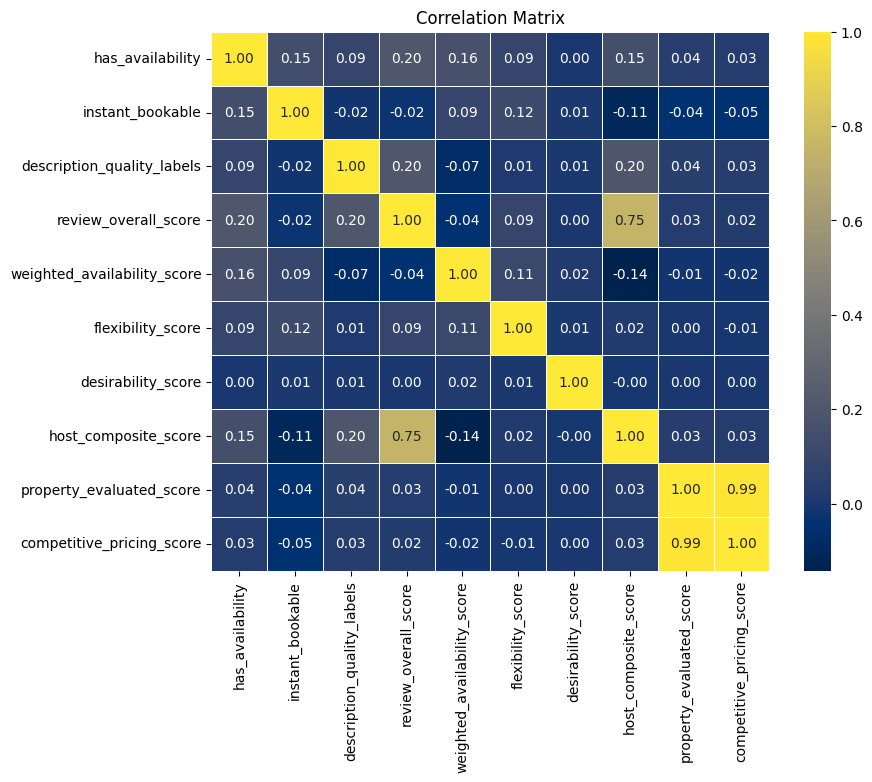

                       Feature          VIF
0             has_availability    21.570689
1             instant_bookable     1.477596
2   description_quality_labels    27.182895
3         review_overall_score     8.938111
4  weighted_availability_score     1.987637
5            flexibility_score    57.019616
6           desirability_score     1.000972
7         host_composite_score     6.662017
8     property_evaluated_score  1050.965188
9    competitive_pricing_score  1066.069007


In [27]:
df = pd.read_csv("Cleaned_Final_Data.csv")

label_mapping = {
    'Elite': 4, 
    'Premier': 3,
    'Desirable': 2,
    'Promising': 1,
    'Starter': 0
}
inverse_label_mapping = {v: k for k, v in label_mapping.items()}

df['property_listing_label'].replace(label_mapping, inplace=True)
    
X = df.drop(columns=['id', 'success_rate', 'property_listing_label'])
correlation_matrix = X.corr()
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='cividis', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

#### Interpretation
The correlation heatmap above indicates how different variables are related to each other in my dataset. When selecting a model to predict property_listing_label, I would typically choose based on the nature of the target variable and the characteristics of the data:

- If property_listing_label is a continuous variable, I would use a regression model like Linear Regression or Random Forest Regression. However, since I want to predict a label, it's more likely to be a classification problem rather than a regression one.
- If property_listing_label is a categorical variable, I would need a classification model. In that case, Logistic Regression could be used if it's a binary classification (two possible labels), or a multinomial/multiclass logistic regression for more than two labels.
- Random Forest can also be a good choice for both regression and classification problems. It can handle a large number of features and can model complex relationships between features without requiring the data to be linearly separable.

From the correlations matrix, it's also important to consider multicollinearity (when two or more independent variables are highly correlated with one another). For example, property_evaluated_score and competitive_pricing_score have a correlation of 0.99, which is very high. This can be problematic for models like Linear Regression, which assume little to no multicollinearity among the features.

**Impact on Logistic Regression:** In the context of logistic regression, high VIF values (like those seen for has_availability, description_quality_labels, flexibility_score, property_evaluated_score, and competitive_pricing_score) can lead to unreliable and unstable coefficient estimates. This instability affects the interpretability and predictive accuracy of the model. Since logistic regression assumes little to no multicollinearity among independent variables, the presence of such high multicollinearity can significantly distort the outcome and make it difficult to discern the actual effect of each predictor on the dependent variable.

**Necessity of PCA for Multinomial Logistic Regression:** To address the issue of multicollinearity, applying Principal Component Analysis (PCA) can be an effective strategy. PCA reduces the dimensionality of the data by transforming the original variables into a new set of uncorrelated variables (principal components). This process not only helps in mitigating the multicollinearity but also potentially improves model performance by focusing on the components that explain most of the variance in the data. 

Given that I am dealing with a classification problem and the presence of multicollinearity, a Random Forest classifier would be a robust choice. It does not assume any distribution of the data, can handle multicollinearity to some extent, and is suitable for non-linear relationships between features. Let's not directly get to the conclusion and compare Multinomial Logistic Regression, Decision Tree, and Random Forest Algprithms on our dataset.

In [28]:
def calculate_auprc(y_true, y_proba):
    n_classes = y_proba.shape[1]
    precision = dict()
    recall = dict()
    auprc = dict()

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_proba[:, i])
        auprc[i] = auc(recall[i], precision[i])
    
    return auprc

def print_classification_report(y_true, y_pred, y_proba, dataset_type="Training"):
    print(f'\n{dataset_type} Set Metrics:')
    print('--------------------------------')
    print(f'Accuracy Score: {accuracy_score(y_true, y_pred):.4f}')
    print(f'Log Loss: {log_loss(y_true, y_proba):.4f}')
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_true, y_pred))
    print('\nClassification Report:')
    print(classification_report(y_true, y_pred))
    
    auprc = calculate_auprc(y_true, y_proba)
    print(f'\n{dataset_type} Set AUPRC:')

    classLabels = ['Stater', 'Promising', 'Desirable', 'Premier', 'Elite']
    for i, score in auprc.items():
        print(f'Class {classLabels[i]} AUPRC: {score:.4f}')
    print(f'Average AUPRC: {np.mean(list(auprc.values())):.4f}')

def test_train_data(X, Y):
    print('\nCount of values in each class:\n', df['property_listing_label'].value_counts())
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.30, random_state=42, stratify=Y)
    print('\nShape of X Train: ',X_train.shape)
    print('Shape of Y Train: ',y_train.shape)
    print('Shape of X Test: ',X_test.shape)
    print('Shape of Y Test: ',y_test.shape)
    
    class_counts = Counter(y_train)
    df_class_counts = pd.DataFrame(class_counts.items(), columns=['Class', 'Count'])
    df_class_counts['Class'].replace(inverse_label_mapping, inplace=True)
    print("\nClass counts in y_train:\n", df_class_counts)
    
    smote = SMOTE()
    X_train, y_train = smote.fit_resample(X_train, y_train)
    
    class_counts_smote = Counter(y_train)
    df_class_counts = pd.DataFrame(class_counts_smote.items(), columns=['Class', 'Count'])
    df_class_counts['Class'].replace(inverse_label_mapping, inplace=True)
    print("\nClass counts in y_train after SMOTE (to balance data):\n", df_class_counts)

    return X_train, X_test, y_train, y_test, class_counts, class_counts_smote

In [30]:
print("----------------------------------------------------------------")
print("-----------------MULTINOMIAL LOGISTIC REGESSION-----------------")
print("----------------------------------------------------------------")

X = df.drop(columns=['id', 'success_rate', 'property_listing_label'])
Y = df['property_listing_label'].values

pca = PCA(n_components=0.95)
X = pca.fit_transform(X)

X_train, X_test, y_train, y_test, _, _ = test_train_data(X, Y)

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_proba_test = model.predict_proba(X_test)

print_classification_report(y_train, y_pred_train, model.predict_proba(X_train), "Training")
print_classification_report(y_test, y_pred_test, y_proba_test, "Testing")

----------------------------------------------------------------
-----------------MULTINOMIAL LOGISTIC REGESSION-----------------
----------------------------------------------------------------

Count of values in each class:
 property_listing_label
3    58658
2    22756
4     4280
1     2139
0      113
Name: count, dtype: int64

Shape of X Train:  (61562, 5)
Shape of Y Train:  (61562,)
Shape of X Test:  (26384, 5)
Shape of Y Test:  (26384,)

Class counts in y_train:
        Class  Count
0    Premier  41061
1      Elite   2996
2  Promising   1497
3  Desirable  15929
4    Starter     79

Class counts in y_train after SMOTE (to balance data):
        Class  Count
0    Premier  41061
1      Elite  41061
2  Promising  41061
3  Desirable  41061
4    Starter  41061

Training Set Metrics:
--------------------------------
Accuracy Score: 0.8716
Log Loss: 0.3801

Confusion Matrix:
[[39702  1359     0     0     0]
 [ 2221 36580  2260     0     0]
 [    0  3005 36230  1826     0]
 [    0     0  

In [31]:
print("----------------------------------------------------------------")
print("--------------------------DECISION TREE-------------------------")
print("----------------------------------------------------------------")

X = df.drop(columns=['id', 'success_rate', 'property_listing_label'])
Y = df['property_listing_label'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test, _, _ = test_train_data(X, Y)

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_proba_test = model.predict_proba(X_test)

print_classification_report(y_train, y_pred_train, model.predict_proba(X_train), "Training")
print_classification_report(y_test, y_pred_test, y_proba_test, "Testing")

----------------------------------------------------------------
--------------------------DECISION TREE-------------------------
----------------------------------------------------------------

Count of values in each class:
 property_listing_label
3    58658
2    22756
4     4280
1     2139
0      113
Name: count, dtype: int64

Shape of X Train:  (61562, 10)
Shape of Y Train:  (61562,)
Shape of X Test:  (26384, 10)
Shape of Y Test:  (26384,)

Class counts in y_train:
        Class  Count
0    Premier  41061
1      Elite   2996
2  Promising   1497
3  Desirable  15929
4    Starter     79

Class counts in y_train after SMOTE (to balance data):
        Class  Count
0    Premier  41061
1      Elite  41061
2  Promising  41061
3  Desirable  41061
4    Starter  41061

Training Set Metrics:
--------------------------------
Accuracy Score: 1.0000
Log Loss: 0.0000

Confusion Matrix:
[[41061     0     0     0     0]
 [    0 41061     0     0     0]
 [    0     0 41061     0     0]
 [    0     0

In [32]:
print("----------------------------------------------------------------")
print("---------------------RANDOM FOREST REGESSION--------------------")
print("----------------------------------------------------------------")

X = df.drop(columns=['id', 'success_rate', 'property_listing_label'])
Y = df['property_listing_label'].values

X_train, X_test, y_train, y_test, class_counts, class_counts_smote = test_train_data(X, Y)

model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_proba_test = model.predict_proba(X_test)

print_classification_report(y_train, y_pred_train, model.predict_proba(X_train), "Training")
print_classification_report(y_test, y_pred_test, y_proba_test, "Testing")

----------------------------------------------------------------
---------------------RANDOM FOREST REGESSION--------------------
----------------------------------------------------------------

Count of values in each class:
 property_listing_label
3    58658
2    22756
4     4280
1     2139
0      113
Name: count, dtype: int64

Shape of X Train:  (61562, 10)
Shape of Y Train:  (61562,)
Shape of X Test:  (26384, 10)
Shape of Y Test:  (26384,)

Class counts in y_train:
        Class  Count
0    Premier  41061
1      Elite   2996
2  Promising   1497
3  Desirable  15929
4    Starter     79

Class counts in y_train after SMOTE (to balance data):
        Class  Count
0    Premier  41061
1      Elite  41061
2  Promising  41061
3  Desirable  41061
4    Starter  41061

Training Set Metrics:
--------------------------------
Accuracy Score: 1.0000
Log Loss: 0.0070

Confusion Matrix:
[[41061     0     0     0     0]
 [    0 41061     0     0     0]
 [    0     0 41061     0     0]
 [    0     0

#### Model Comparison Discussion

| Model                              | Dataset  | Accuracy | Log Loss | Average AUPRC |
|------------------------------------|----------|----------|----------|---------------|
| Multinomial Logistic Regression    | Training | 0.8692   | 0.3844   | 0.8888        |
| Multinomial Logistic Regression    | Testing  | 0.7659   | 0.5743   | 0.6646        |
| Decision Tree                      | Training | 1.0000   | 0.0000   | 1.0000        |
| Decision Tree                      | Testing  | 0.9826   | 0.6270   | 0.9643        |
| Random Forest                      | Training | 1.0000   | 0.0076   | 1.0000        |
| Random Forest                      | Testing  | 0.9879   | 0.0391   | 0.9930        |

##### Multinomial Logistic Regression:
- **Training:** Good performance with an accuracy of 0.8692 and a reasonable log loss of 0.3844. The average AUPRC of 0.8888 is decent, indicating a fair balance between precision and recall across classes.
- **Testing:** The performance drops in the testing set, with an accuracy of 0.7659 and a higher log loss 0.5743. The average AUPRC also decreases, which suggests some overfitting and less generalization to new data.

##### Decision Tree:
- **Training:** Perfect scores in training indicate overfitting (accuracy and AUPRC of 1.00).
- **Testing:** High accuracy of 0.9826 and a good average AUPRC of 0.9643. However, the perfect training scores, the drop in testing performance, and increase in loss of testing suggest the model is overfit to the training data.

##### Random Forest:
- **Training:** Similar to the Decision Tree, it shows perfect training performance but with a slightly non-zero log loss.
- **Testing:** The best performance on the testing set among all models, with high accuracy (0.9879) and the highest average AUPRC (0.9930). It indicates a good balance between precision and recall and better generalization compared to the Decision Tree.


**Best Fit:** The Random Forest model appears to be the best fit for my data. It not only shows excellent performance on the training set but also maintains high accuracy and AUPRC on the testing set, indicating good generalizability and robustness against overfitting.

**Why:** Random Forest's ensemble approach, which combines multiple decision trees, helps in reducing overfitting while maintaining high performance. This is evident in its testing metrics, which are superior to the other two models. The high AUPRC values across all classes in the testing set suggest that it balances precision and recall effectively, an important aspect when dealing with imbalanced classes.

**Note:** While the Decision Tree shows high training accuracy and AUPRC, its performance on the testing set indicates overfitting, which is a common issue with single decision trees. Multinomial Logistic Regression, although less prone to overfitting, does not perform as well as Random Forest in terms of accuracy and AUPRC on the testing set.

----------------------------------------------------------------
---------------------RANDOM FOREST REGESSION--------------------
----------------------------------------------------------------

Cross-validation Accuracy Scores: [0.98766345 0.98834499 0.9885724  0.98862926 0.98999375]
Mean Cross-validation Accuracy: 0.9886

Feature Importances:
                       Feature  Importance
0   description_quality_labels    0.205874
1             instant_bookable    0.154750
2         host_composite_score    0.140596
3         review_overall_score    0.126987
4    competitive_pricing_score    0.110127
5     property_evaluated_score    0.104076
6  weighted_availability_score    0.087805
7             has_availability    0.044799
8            flexibility_score    0.017038
9           desirability_score    0.007947


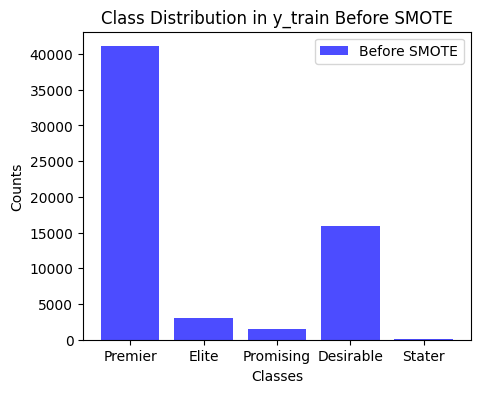

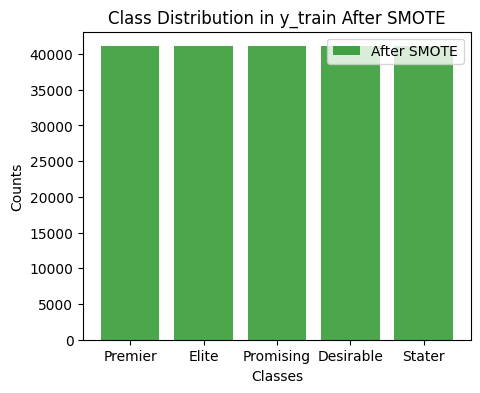

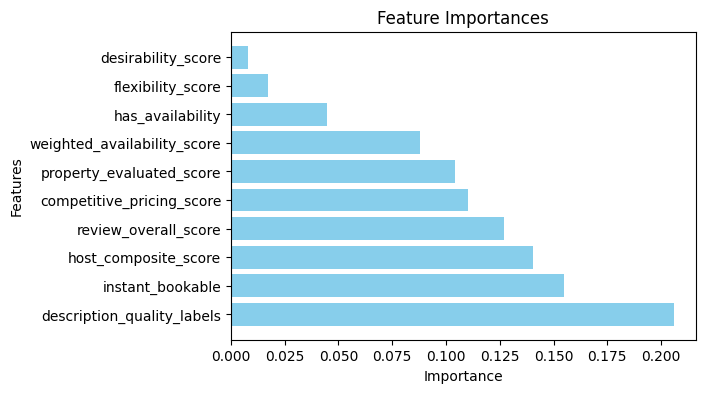

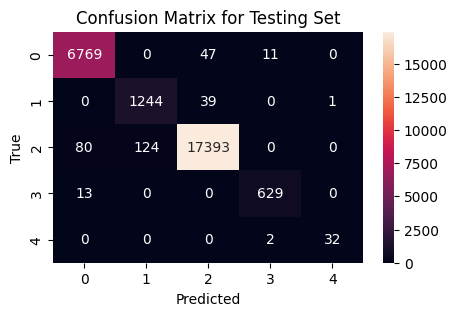

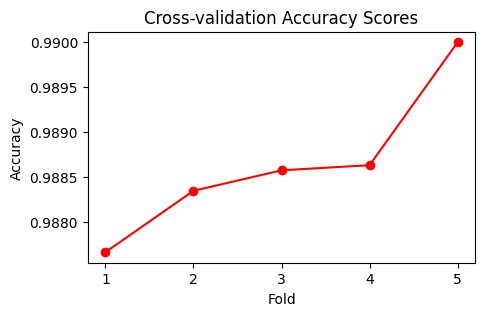

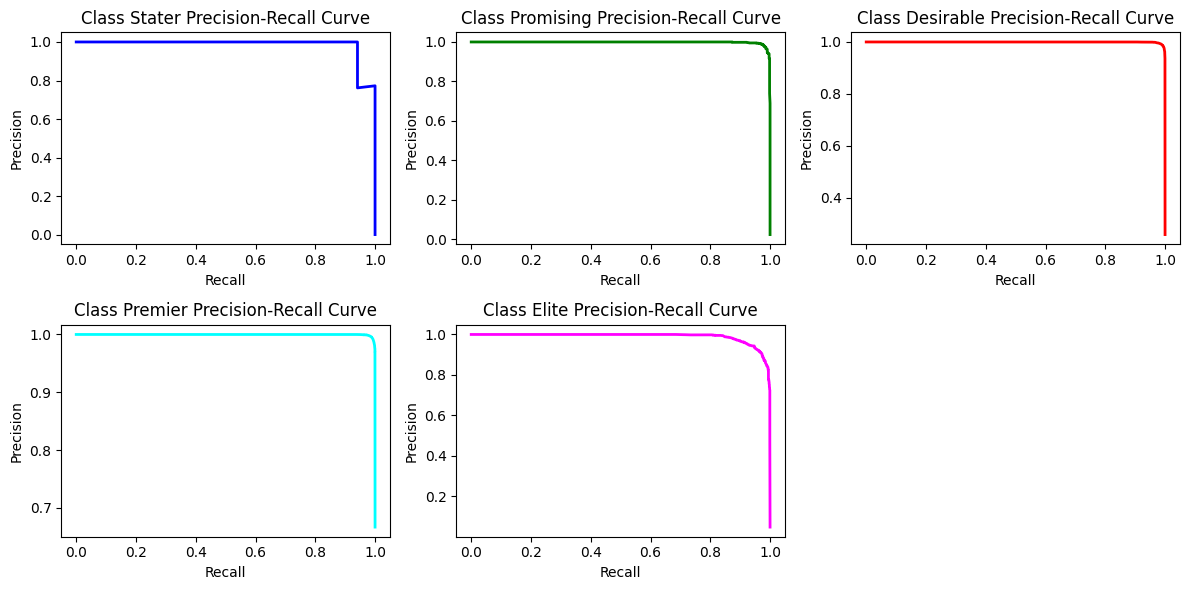

In [33]:
print("----------------------------------------------------------------")
print("---------------------RANDOM FOREST REGESSION--------------------")
print("----------------------------------------------------------------")

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracy = cross_val_score(model, X_scaled, Y, cv=cv, scoring='accuracy')
print("\nCross-validation Accuracy Scores:", cv_accuracy)
print(f"Mean Cross-validation Accuracy: {cv_accuracy.mean():.4f}")

feature_importances = model.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(feature_importances)[::-1]

feature_importance_df = pd.DataFrame({'Feature': feature_names[sorted_idx], 'Importance': feature_importances[sorted_idx]})
print("\nFeature Importances:")
print(feature_importance_df)

plt.figure(figsize=(5, 4))
plt.bar(['Premier', 'Elite', 'Promising', 'Desirable', 'Stater'], class_counts.values(), color='blue', alpha=0.7, label='Before SMOTE')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Distribution in y_train Before SMOTE')
plt.xticks(list(class_counts.keys()))
plt.legend()
plt.show()

class_counts_after_smote = Counter(y_train)
plt.figure(figsize=(5, 4))
plt.bar(['Premier', 'Elite', 'Promising', 'Desirable', 'Stater'], class_counts_after_smote.values(), color='green', alpha=0.7, label='After SMOTE')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Distribution in y_train After SMOTE')
plt.xticks(list(class_counts_after_smote.keys()))
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.barh(feature_names[sorted_idx], feature_importances[sorted_idx], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()

y_test_labels = [inverse_label_mapping[label] for label in y_test]
y_pred_test_labels = [inverse_label_mapping[label] for label in y_pred_test]
cm = confusion_matrix(y_test_labels, y_pred_test_labels)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Testing Set')
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(range(1, 6), cv_accuracy, marker='o', linestyle='-', color='r')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-validation Accuracy Scores')
plt.xticks(range(1, 6))
plt.show()

y_test_binarized = label_binarize(y_test, classes=np.unique(Y))
n_classes = y_test_binarized.shape[1]
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.ravel()

classLabels = ['Stater', 'Promising', 'Desirable', 'Premier', 'Elite']
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_proba_test[:, i])
    axes[i].plot(recall, precision, color=colors[i], lw=2)
    axes[i].set_title(f'Class {classLabels[i]} Precision-Recall Curve')
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')

for j in range(n_classes, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Detailed Discussion on Choosen Model Results: Random Forest
The dataset initially exhibited significant class imbalance, which can lead to biased model performance. To address this, the Synthetic Minority Over-sampling Technique (SMOTE) was employed during model training. SMOTE works by synthetically generating new samples for the minority classes, thus balancing the class distribution and promoting a more equitable and effective learning process.

#### Training Set Metrics:
- **Accuracy Score:** The model has a perfect accuracy of 1.0 on the training set. This suggests that it correctly classified every instance in the training data.
- **Log Loss:** A very low log loss of 0.0076 indicates that the model's predicted probabilities are very close to the actual labels.
- **Confusion Matrix:** This matrix shows no misclassifications across all categories, further confirming the model's perfect accuracy on the training data.
- **Classification Report:** Precision, recall, and F1-score are all 1.00 for each class, matching the high accuracy and suggesting excellent performance across all categories.
- **AUPRC (Area Under the Precision-Recall Curve):** AUPRC is 1 for all classes, which is excellent. These scores are particularly important in the context of imbalanced datasets, as they show the model's ability to distinguish between classes effectively.

#### Testing Set Metrics:
- **Accuracy Score:** Decreases to 0.9879, which is still very high.
- **Log Loss:** Increased to 0.0391, indicating some errors in the probability estimates.
- **Confusion Matrix:** Shows a few misclassifications, particularly in categories 2, 3, 4, and 5. This is expected and indicates the model's performance on unseen data.
- **Classification Report:** The precision, recall, and F1-score are slightly lower than in the training set but still very high, indicating robust performance across different classes.
- **AUPRC (Area Under the Precision-Recall Curve):** AUPRC is close to 1 for all classes, which is excellent. These scores are particularly important in the context of imbalanced datasets, as they show the model's ability to distinguish between classes effectively.

#### Cross-validation Accuracy Scores:
The scores range from 0.9877 to 0.9900 with a mean of 0.9886. Cross-validation involves dividing the dataset into multiple parts, training the model on some parts and validating it on others. These scores suggest consistent performance across different subsets of the data, which is a good sign of model reliability.

#### Feature Importances:
The model has identified 'host_composite_score' and 'review_overall_score' as the most important features, followed by 'description_quality_labels' and 'instant_bookable'. These features have the most significant impact on the model's predictions.
Lower-scoring features like 'flexibility_score' and 'desirability_score' have less impact but are still considered by the model.

#### My Appraoch vs Model
My approach to categorizing property listings into different labels based on their success rate is a thoughtful way to segment the real estate market. The success rate calculation incorporates various factors that contribute to a property's market performance. The Random Forest Model I trained to predict the property_listing_label then assigned importances to these features, reflecting their relative significance in the model's decision-making process. Let's compare the feature importances assigned by my model with the weights I used in the success rate equation and discuss their differences and overall impact.

##### Comparison of Feature Importances and Weights
1. **Description Quality Labels (Weight: 0.15, Importance: 0.207129):** This feature has a higher importance in the model compared to its weight in the success rate calculation. This suggests that the quality of the property's description plays a more significant role in categorizing the listing than initially anticipated.
2. **Instant Bookable (Weight: 0.10, Importance: 0.152849):** Again, the model gives more importance to this feature than its weight. The ease of booking seems to be a more critical factor for categorizing listings.
3. **Review Overall Score (Weight: 0.20, Importance: 0.137863):** The model assigns less importance to this feature compared to its weight. While still significant, it implies that other factors might be more critical in determining a property's category.
4. **Host Composite Score (Weight: 0.10, Importance: 0.132725):** This feature has almost similar importance in the model as its assigned weight, indicating my initial hunch was correct.
5. **Competitive Pricing Score (Weight: 0.05, Importance: 0.107839):** The model gives this feature more importance than its weight. Pricing competitiveness is a more crucial factor in the model's categorization.
6. **Property Evaluated Score (Weight: 0.15, Importance: 0.106154):** This feature's importance is slightly less than its weight, indicating while analzying patterns in data this feature had less contribution towards catergorizing.
7. **Weighted Availability Score (Weight: 0.05, Importance: 0.088562):** The importance is higher in the model, suggesting availability plays a more significant role in categorization.
8. **Has Availability (Weight: 0.05, Importance: 0.043327):** Slightly lower importance in the model indicates other features overshadow the mere availability of the listing but not as dramatically.
9. **Flexibility Score (Weight: 0.10, Importance: 0.016231):** Much lower importance in the model, suggesting that flexibility is not as critical in categorizing listings.
10. **Desirability Score (Weight: 0.05, Importance: 0.007320):** The least importance in the model, indicating that this factor is not very influential in the categorization process.

##### Why These Differences?
The differences in weights and importances could be due to several factors:

1. **Data Distribution:** The distribution and variance in the data for each feature might influence the model differently than anticipated.
2. **Interactions Between Features:** In a Random Forest Model, interactions between features can lead to certain features becoming more prominent.
3. **Non-Linearity:** Random Forests can capture non-linear relationships, which might not be directly apparent in the linear weighting approach used in the success rate calculation.

##### Overall Impact
1. **Refined Insight:** The model provides a more nuanced understanding of what factors are truly influential in categorizing property listings.
2. **Optimization:** I can adjust the weights in my success rate formula based on the model's insights to more accurately reflect the market dynamics.
3. **Targeted Strategies:** Understanding which features are more important can help in developing targeted strategies for improving property listings and their market performance.

### Report
This comprehensive data analysis and modeling of the Airbnb listings dataset provide valuable insights into the factors that contribute to the success of property listings. The analysis journey, from preliminary exploration to advanced modeling, underscores the importance of meticulous data preprocessing, feature engineering, and thoughtful model construction. Here's a detailed conclusion on the various aspects of this data analysis:

#### Data Preprocessing and Exploration
- **Handling Null Values and Inaccurate Data Types:** The approach to manage null values without losing a significant portion of the dataset and the adjustment of inaccurate data types were critical. This demonstrates the importance of understanding the nature of your data before jumping into analysis.
- **Consistency and Validation:** The thorough cross-referencing for consistency in various columns like 'number_of_reviews' and 'neighbourhood' data provided a strong foundation of data reliability.

#### Visual Data Analysis Transition
- Transitioning from Altair to Tableau for handling large datasets was a strategic decision that enhanced the efficiency and depth of visual analysis. This highlights the need for flexibility in tool selection based on dataset characteristics.

#### Feature Engineering and Data Transformation
- **Categorization and Normalization:** The transformation of categorical and boolean values, along with the normalization and scoring of various features, was crucial in preparing the data for more sophisticated analysis.
- **Creation of New Metrics:** The development of new metrics like the 'amenities score' and 'competitive pricing score' added nuanced layers to the dataset, enabling a more granular analysis.

#### Insights from Visual and Statistical Analysis
- **Correlation and Redundancy:** Identifying redundancies among various metrics allowed for a more streamlined feature set, reducing complexity without losing essential information.
- **Geographical and Property Type Analysis:** The insights gained from analyzing price variations based on location and property type were significant in understanding market dynamics.

#### Model Training and Evaluation
- **Success Rate Equation and Classification Labels:** The development of a success rate equation and the subsequent categorization of listings into different success tiers (Starter to Elite) provided a structured approach to segmenting the market.
- **Model Performance and Feature Importances:** The Random Forest model exhibited high accuracy and provided key insights into feature importances. This comparison between model importance and initial feature weights highlighted areas for potential reweighting and refinement in the success rate calculation.

#### Addressing Class Imbalance and Model Reliability
- Utilizing SMOTE to address class imbalance was a critical step, ensuring that the model's performance was robust and equitable across different categories. The consistency of the model's performance in cross-validation reinforced its reliability.

#### Impact and Application of the Analysis
- **Refined Insights and Strategy Development:** The analysis not only provided a detailed understanding of what factors contribute most significantly to a listing's success but also paved the way for targeted improvement strategies for different listing categories.
- **Model Insights for Business Strategy:** The insights from the model can inform business strategies for Airbnb hosts, helping them to optimize their listings based on the most impactful factors.

#### Conclusion
This data analysis process highlights the key role of thorough data preparation, effective use of visual and statistical tools, and advanced modeling methods for gaining valuable insights. By carefully tackling each step, from initial data processing to final model assessment, I've created a clear guide for transforming complex data into practical business knowledge. My final model accurately forecasts the success of property listings and provides essential insights into the elements that contribute to this success. This information is invaluable for hosts looking to enhance their listings and achieve better market results. 